In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import os
from numba import njit

import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
inputfile = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/input_truth/gammas_235fbnoise_235thres.hdf5"
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/ThresholdStudy/simfraction_photon_235noise_235thres"
os.makedirs(outputdir, exist_ok=True)


In [5]:
store_ele = pd.HDFStore(inputfile)
df =store_ele['df']
store_ele.close()
df.rename(columns={"output.csv":"window_index"}, inplace=True)
df = df.iloc[:-1]

# Having a look at the dataset
It contains all the cluster around each caloparticle. 
Both the clusters inside and output the "dynamic window" limits are included, so that all the truth level info can be analyzed.

In [6]:
df

window_index           en          et  ieta   iphi       eta       phi  \
0         slzvdwlf  3117.769775  419.092458  40.0   40.0 -2.695381 -2.337081   
1         luuordmu   771.809814  210.868356  74.0   31.0  1.971445 -0.677516   
2         opnaxtkb   495.531250  438.359880  29.0  340.0  0.505333 -0.529209   
3         iabqdbyj     9.405126    8.091558 -32.0  301.0 -0.562364 -1.222512   
4         fwlrnxea   600.966248  112.218946  58.0   31.0 -2.362401 -1.179696   
...            ...          ...         ...   ...    ...       ...       ...   
83492     fggrdsct  1648.936035  251.270876  39.0   39.0 -2.568645 -2.361038   
83493     rghaukhf   542.630249  157.812552  33.0   79.0  1.906318  2.121529   
83494     itjsyvcq   228.440353  129.684352  67.0  205.0  1.166786 -2.882955   
83495     vqjzafqn    79.389076   76.440494 -16.0   20.0 -0.276869  0.152504   
83496     vqjzafqn     1.301491    1.253890 -16.0   29.0 -0.274681  0.312801   

        iz  simfrac_sig    simen_sig  ...  obsPU   calo_simen  calo_simet  \
0     -1.0     0.953256  3091.096603  ...   31.0  3242.665527  435.834990   
1      1.0     0.979788   763.153667  ...   31.0   778.894958  212.823217   
2      0.0     0.983129   481.314494  ...   31.0   489.574188  433.081899   
3      0.0     0.856202     9.150103  ...   31.0    10.686847    9.192797   
4     -1.0     0.946775   572.913553  ...   31.0   605.034241  112.976740   
...    ...          ...          ...  ...    ...          ...         ...   
83492 -1.0     0.950175  1638.925882  ...   49.0  1724.776489  262.689525   
83493  1.0     0.977175   518.841047  ...   49.0   530.924194  154.413430   
83494  0.0     0.973974   219.532878  ...   49.0   225.398743  127.974285   
83495  0.0     0.840311    77.503322  ...   49.0    92.231689   88.822829   
83496  0.0     0.012042     1.110632  ...   49.0    92.231689   88.822829   

       calo_simen_good  calo_geneta  calo_genphi  calo_simeta  calo_simphi  \
0          3242.568359    -2.693650    -2.339028    -2.695487    -2.338901   
1           778.861816     1.981111    -0.678070     1.971352    -0.677943   
2           489.573425     0.519207    -0.529280     0.505374    -0.529181   
3            10.686847    -0.548645    -1.224060    -0.562678    -1.221007   
4           604.680542    -2.375117    -1.181751    -2.362417    -1.179677   
...                ...          ...          ...          ...          ...   
83492      1724.755615    -2.573132    -2.361217    -2.569177    -2.361150   
83493       530.904724     1.904219     2.121789     1.906282     2.121552   
83494       225.172607     1.162267    -2.882686     1.166628    -2.882989   
83495        82.415993    -0.282941     0.159693    -0.276171     0.155793   
83496        82.415993    -0.282941     0.159693    -0.276171     0.155793   

        calo_genen  calo_genet  
0      3616.094238  486.911725  
1       802.460938  217.212693  
2       500.673187  440.019419  
3        11.354873    9.836858  
4       635.850281  117.258457  
...            ...         ...  
83492  1776.484253  269.509118  
83493   546.514221  159.261619  
83494   229.148956  130.571118  
83495    94.267319   90.615906  
83496    94.267319   90.615906  

[3424409 rows x 27 columns]

# Building the window

Collecting all the clusters around the same seed by the window_index columns. 
The `calo_match_dataset.py` script collects all the clusters with some caloparticle deposition around each seed. 
The seed in this case is the PFCluster with the highest score for each caloparticle. 

In [7]:
seed = df[(df.is_seed==1)][['window_index','en','eta','et', 'simfrac_sig']]
seed.columns = ['window_index','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("window_index"), on='window_index')

# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)

(array([1857., 4361., 4793., 4438., 4184., 3899., 3758., 3584., 3493.,
        3621., 3702., 3512., 3398., 3416., 3178., 3083., 3073., 3002.,
        2953., 3006., 2735., 2888., 2882., 2832., 2821., 2883., 2833.,
        2760., 2687., 2691., 2651., 2602., 2519., 2585., 2619., 2511.,
        2493., 2482., 2500., 2523., 2434., 2540., 2532., 2421., 2427.,
        2442., 2335., 2361., 2374., 2224.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
        17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ]),
 <BarContainer object of 50 artists>)

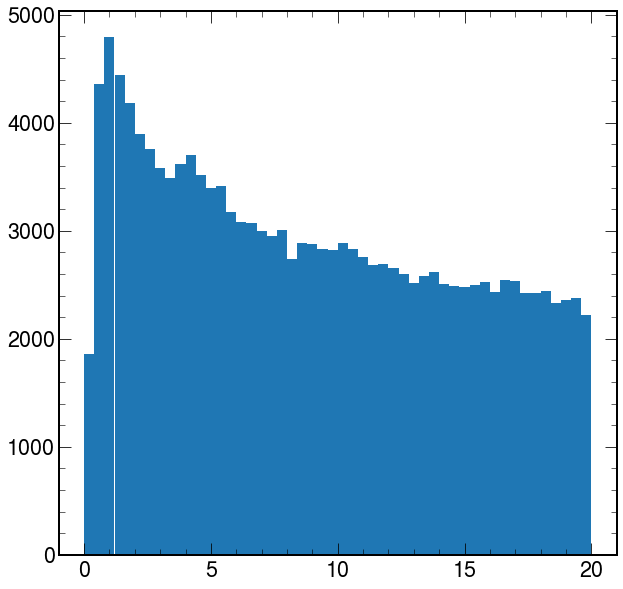

In [8]:
plt.hist(dfb[dfb.is_seed==1].seed_et, bins=50, range=(0,20))

(array([[ 59.,  15.,  24., ...,  34.,   9.,   0.],
        [336., 102., 196., ..., 137.,  83., 217.],
        [254., 142., 196., ..., 119., 146., 131.],
        ...,
        [125., 134., 162., ..., 139., 145., 127.],
        [117., 131., 167., ..., 161., 171., 146.],
        [152., 138., 135., ..., 142., 113., 124.]]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8,
        17.6, 18.4, 19.2, 20. , 20.8, 21.6, 22.4, 23.2, 24. , 24.8, 25.6,
        26.4, 27.2, 28. , 28.8, 29.6, 30.4, 31.2, 32. , 32.8, 33.6, 34.4,
        35.2, 36. , 36.8, 37.6, 38.4, 39.2, 40. ]),
 array([-3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. ,
        -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
         1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <matplotlib.collections.QuadMesh at 0x7fbeed92eb80>)

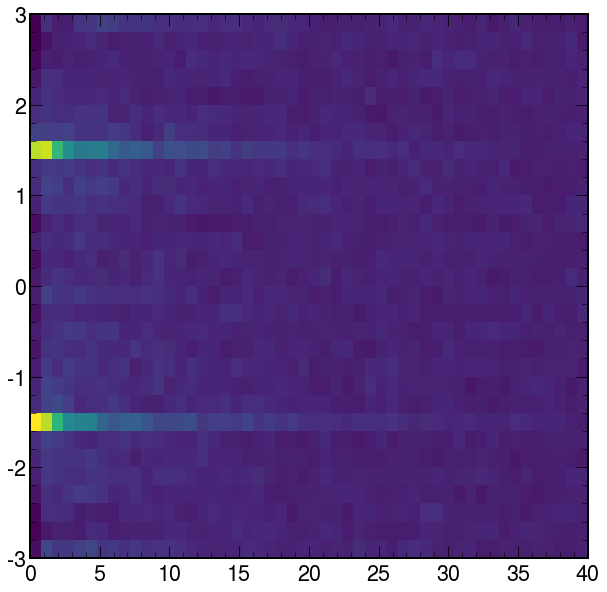

In [9]:
plt.hist2d(dfb[dfb.is_seed==1].seed_et, dfb[dfb.is_seed==1].seed_eta, bins=(50, 30), range=((0,40), (-3,3)))

# Window dimension study

In [10]:
H, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

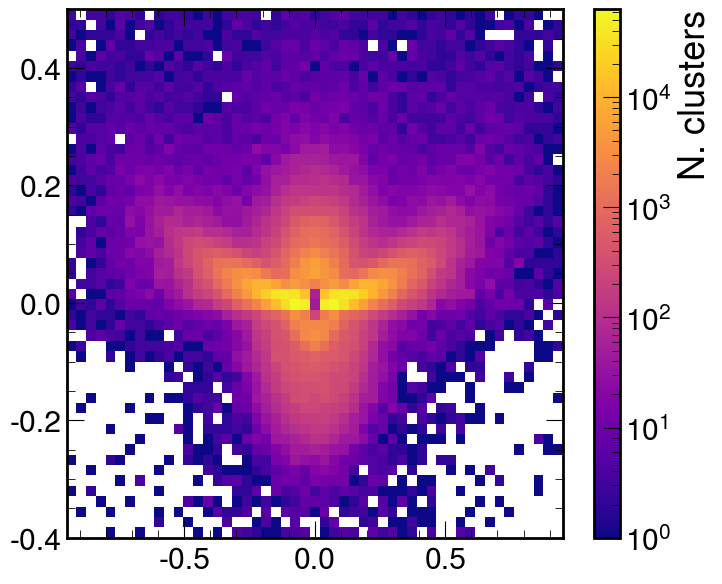

In [11]:
plt.figure(figsize=(8,7), dpi=100)
I = plt.pcolormesh(X, Y, H.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(I, label="N. clusters")

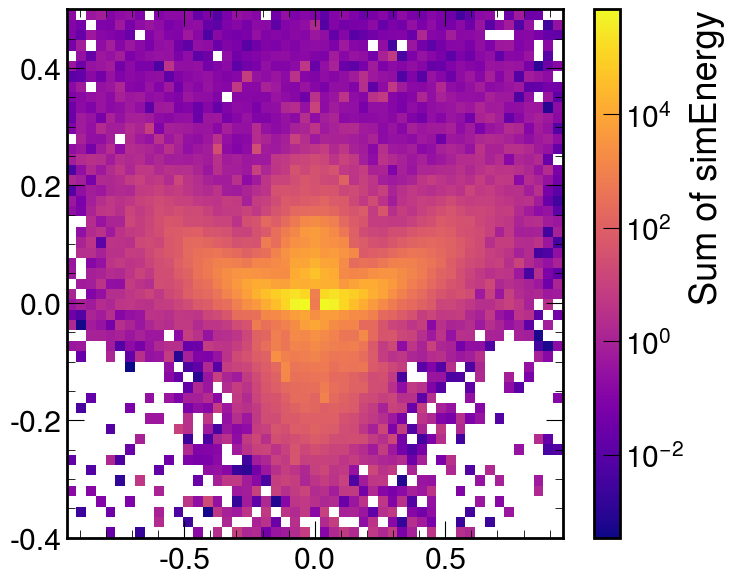

In [12]:
plt.figure(figsize=(8,7), dpi=100)

I = plt.pcolormesh(X, Y, Hfrac.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(label="Sum of simEnergy")

Plotting the normalized distribution of the profiled simEnergy in each bin

/tmp/ipykernel_994/4061902690.py:2: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)


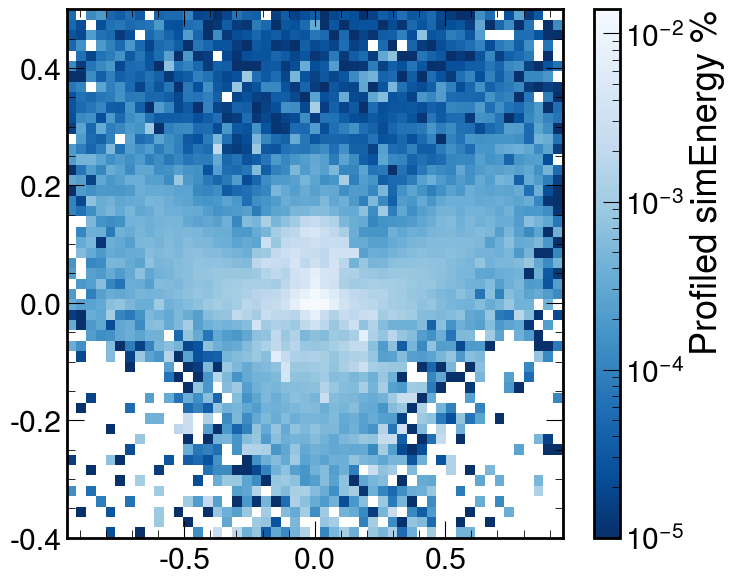

In [13]:
plt.figure(figsize=(8,7), dpi=100)
profile_simen = (Hfrac/H)
np.nan_to_num(profile_simen, copy=False, nan=0.)
prof_simen_perc = profile_simen / np.sum(profile_simen)

I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy %")

#$plt.gca().set_xticklabels(phibins)

Plotting the normalized distribution of the profiled simEnergy/caloEn in each bin

/tmp/ipykernel_994/2531401568.py:10: RuntimeWarning: invalid value encountered in true_divide
  profile_simen2 = (Hfrac2/H2)


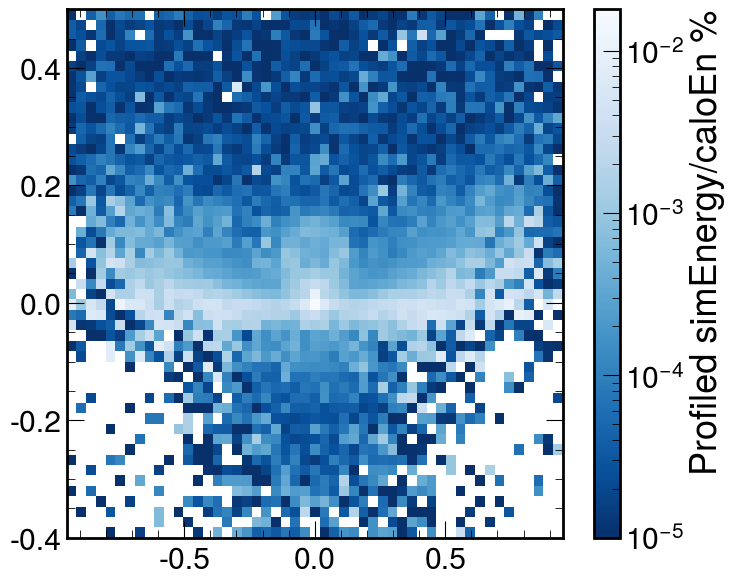

In [14]:
H2, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac2, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig/dfb[dfb.is_seed==0].calo_simen_good, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

plt.figure(figsize=(8,7), dpi=100)
profile_simen2 = (Hfrac2/H2)
np.nan_to_num(profile_simen2, copy=False, nan=0.)
prof_simen_perc2 = profile_simen2 / np.sum(profile_simen2)

I = plt.pcolormesh(X, Y, prof_simen_perc2.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy/caloEn %")

#$plt.gca().set_xticklabels(phibins)

### Studying the profile

In [15]:
import numba 
@numba.njit
def get_binrange(X, perc, direction=1):
    S = 0.
    i = 0 if direction>0 else len(X)-1
    while(S<perc):
        S += X[i]
        i += direction
    return i

Text(1, 0, 'ieta, (iphi profiled)')

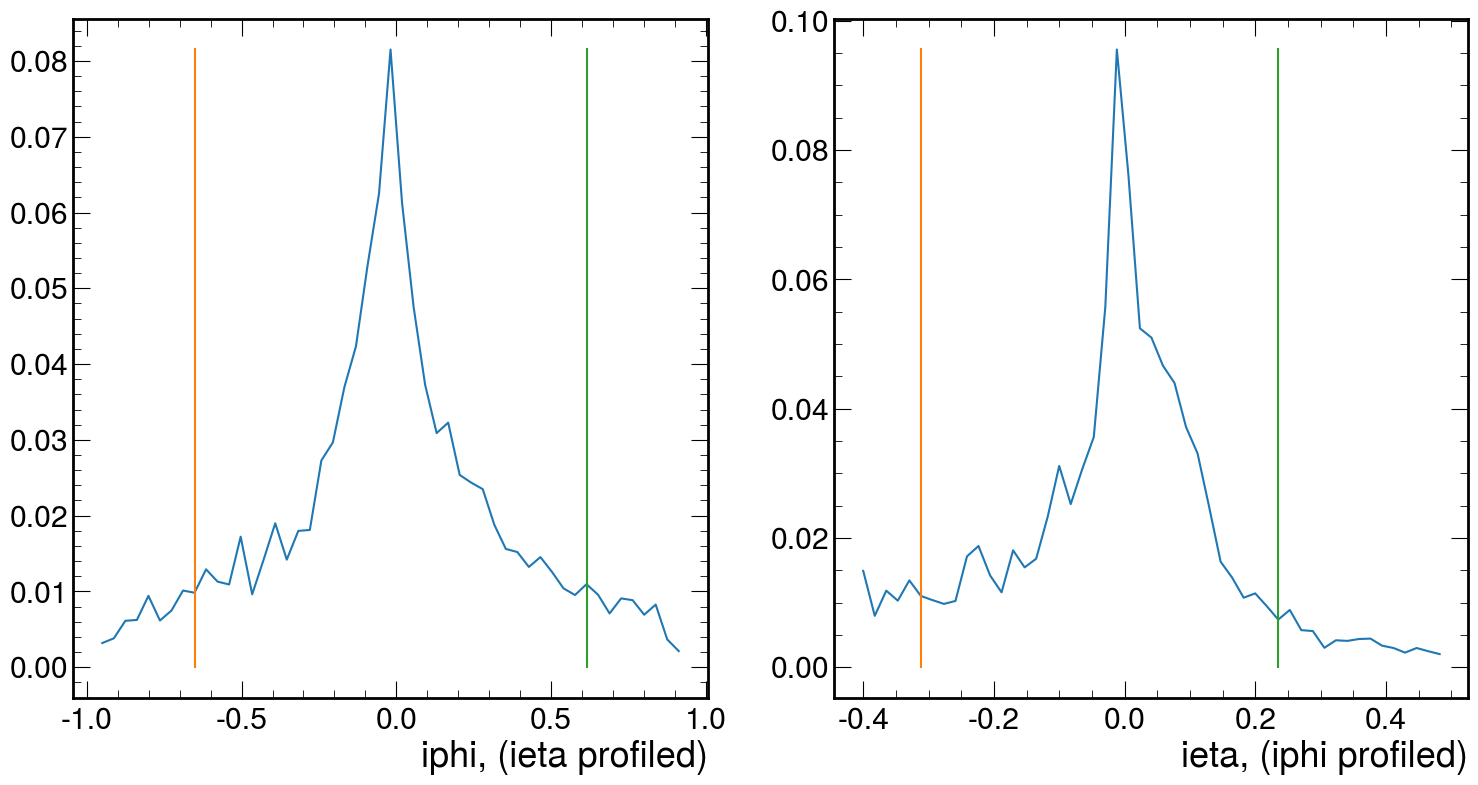

In [16]:
iphi_profile = np.sum(prof_simen_perc, axis=1)
ieta_profile = np.sum(prof_simen_perc.T, axis=1)

prob = 0.05
iphi_min =  get_binrange(iphi_profile,  prob)
iphi_max =  get_binrange(iphi_profile, prob, direction=-1)
ieta_min =  get_binrange(ieta_profile,  prob)
ieta_max =  get_binrange(ieta_profile, prob, direction=-1)

f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
a1.plot(phibins[:-1], iphi_profile)
a2.plot(etabins[:-1], ieta_profile)
a1.plot([phibins[iphi_min], phibins[iphi_min]], [0,np.max(iphi_profile)])
a1.plot([phibins[iphi_max], phibins[iphi_max]], [0,np.max(iphi_profile)])
a2.plot([etabins[ieta_min], etabins[ieta_min]], [0,np.max(ieta_profile)])
a2.plot([etabins[ieta_max], etabins[ieta_max]], [0,np.max(ieta_profile)])

a1.set_xlabel("iphi, (ieta profiled)")
a2.set_xlabel("ieta, (iphi profiled)")

## Now we do the same in bins of eta

In [17]:
eta_bins_wind = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0, 2.4, 3.0]

dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))

/tmp/ipykernel_994/1576785483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))


### Plotting simEn profiles

/tmp/ipykernel_994/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/42400

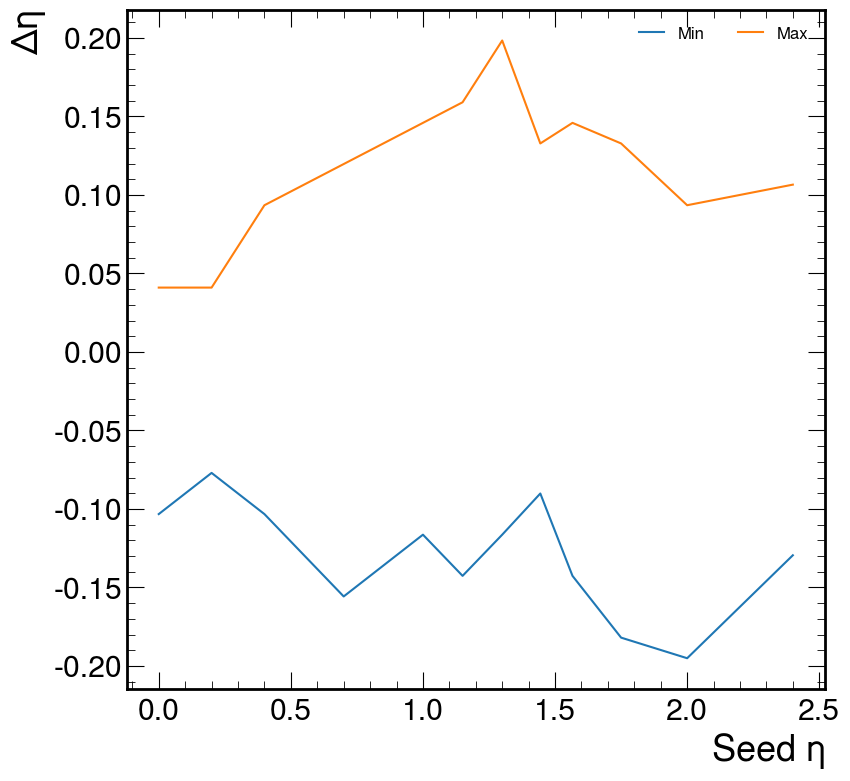

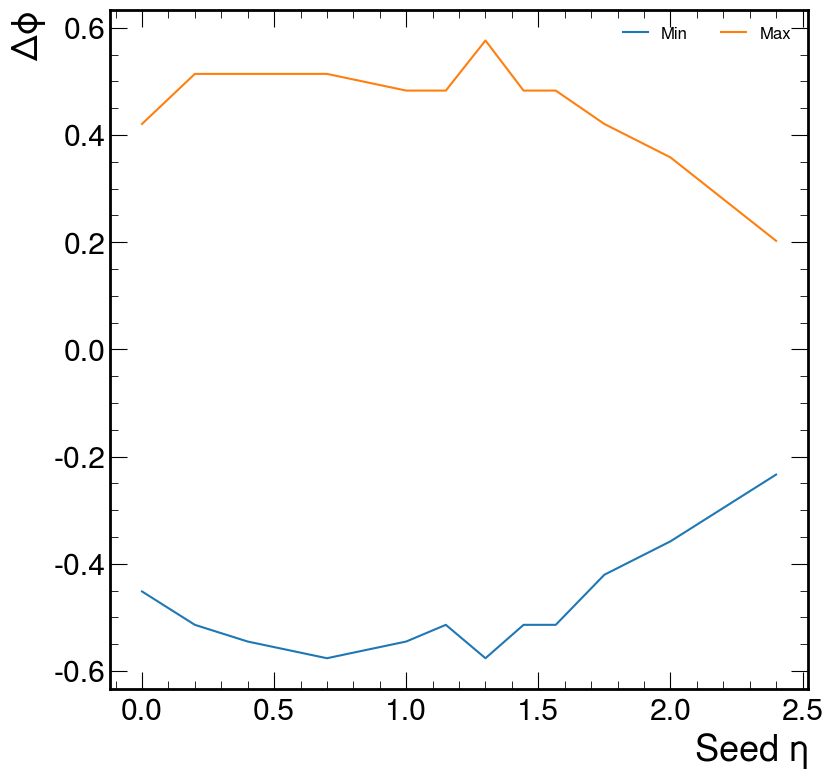

In [18]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig,  # --> simEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Plotting by simEn/CaloEn profiled

/tmp/ipykernel_994/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/38770

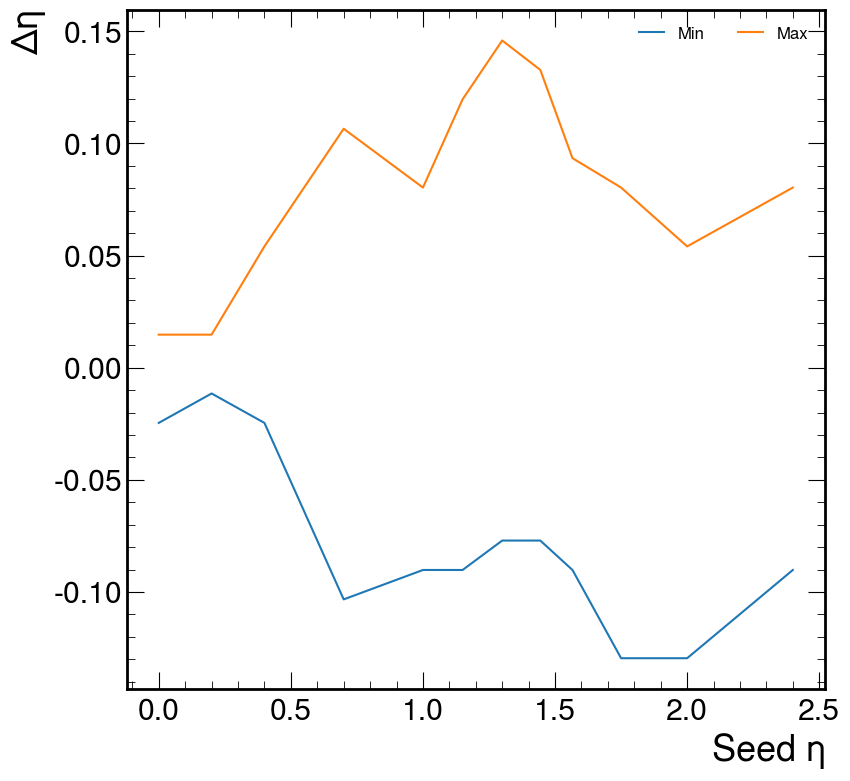

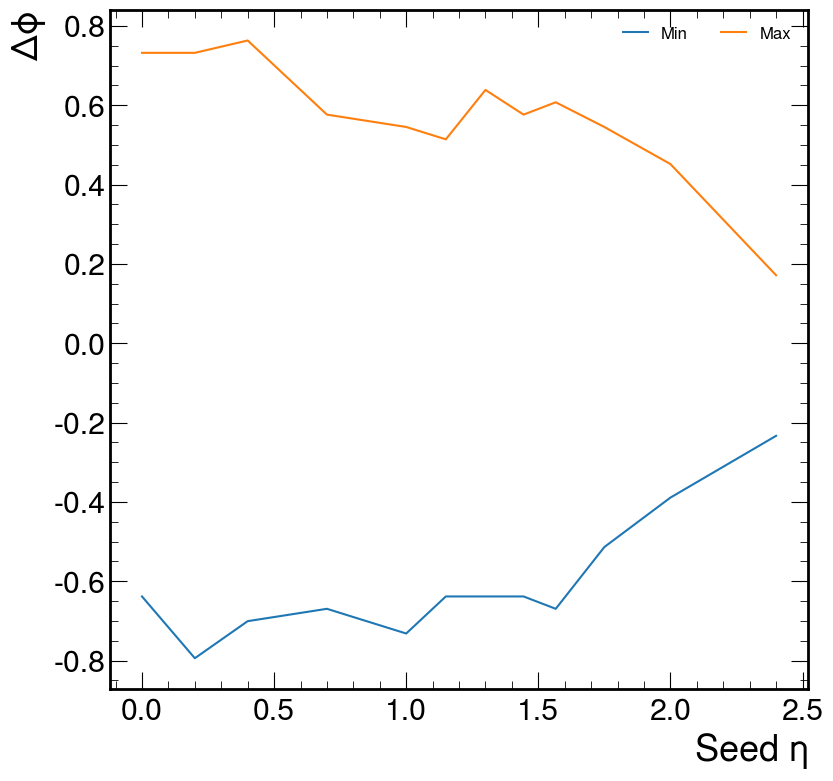

In [19]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig/df.calo_simen_good,  # ===> simEn/CaloEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy/CaloEn %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Approximate the trend as a linear function

In [20]:
def deta_window(seed_eta):
    EB_max = (0.1/1.5)*seed_eta + 0.1
    EB_min = np.ones_like(seed_eta) * (-0.1)
    EE_max = (0.1/1.5)*(seed_eta-1.5) + 0.2 
    EE_min = -0.1 + (-0.1/1.5)*(seed_eta-1.5)
    out_max = np.where(seed_eta<= 1.5, EB_max, EE_max)
    out_min = np.where(seed_eta<= 1.5, EB_min, EE_min)
    return out_max, out_min

@njit
def dphi_window(seed_eta):
    return 0.7 + (-0.1/3)*seed_eta,  -0.7 + (0.1/3)*seed_eta



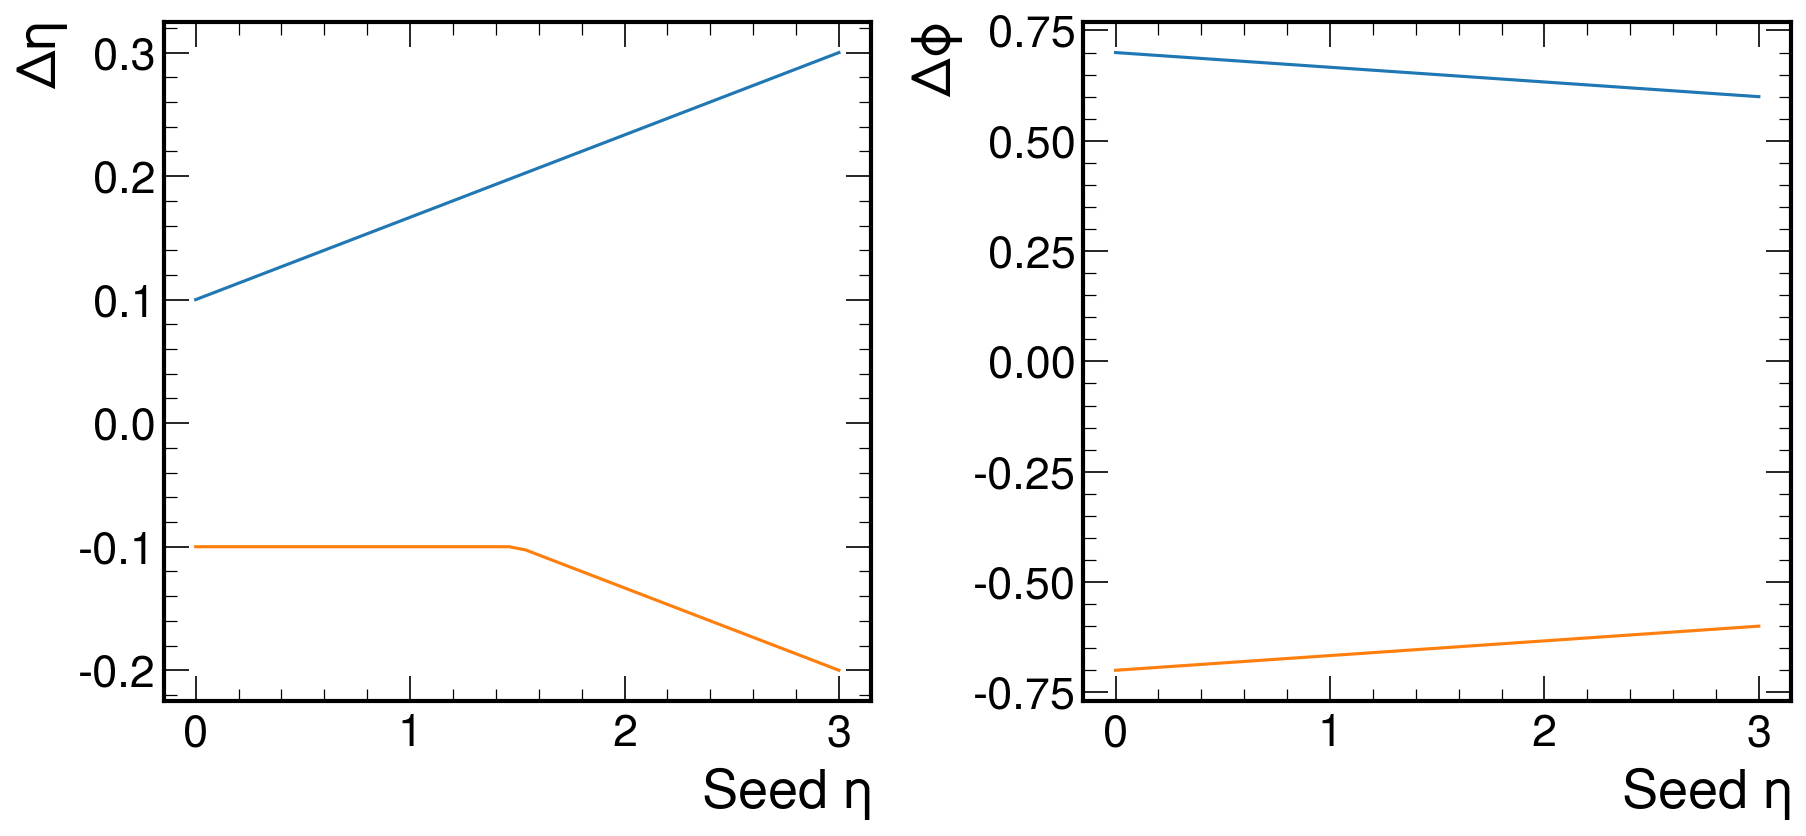

In [21]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)
plt.subplots_adjust(wspace=0.3)
seta = np.linspace(0, 3, 40)
emax, emin = deta_window(seta)
pmax, pmin = dphi_window(seta)
ax.plot(seta, emax)
ax.plot(seta, emin)
ax.set_ylabel("$\Delta\eta$")
ax.set_xlabel("Seed $\eta$")

ay.plot(seta, pmax)
ay.plot(seta, pmin)
ay.set_ylabel("$\Delta\phi$")
ay.set_xlabel("Seed $\eta$")\

outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")


outputdirwind = outputdir + "/windows_simEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")

### Plots of the window with the final cut
Doing it both for simEn profile and also for simEn/CaloEn profile

In [22]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig,  # --> simEN
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_994/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/40230

Empty DataFrame
Columns: []
Index: []

In [23]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig/df.calo_simen_good, # --> simEn/CaloEN 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy/caloEn %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_994/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_994/199248077.py:

Empty DataFrame
Columns: []
Index: []

# Resolution study

Let's study the best threshold for resolution. 
We have to apply the window definition before studying the best threshold.

Get the "seed", in this case the clusters with the highest score for the caloparticle, 
and collect the clusters around them and **apply** the geometrical window we have defined as a function of the seed eta

In [24]:
eta_max, eta_min = deta_window(dfb.seed_eta.abs().values)
phi_max, phi_min = dphi_window(dfb.seed_eta.abs().values)

dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \
                        (dfb.dphi_seed >= phi_min) & (dfb.dphi_seed <= phi_max)    

/tmp/ipykernel_994/3615905916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \


Analyzing the truth level resolution for clusters in the geometrical window

In [25]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [26]:
etas = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0,2.4,3.0]
ets = [ 1,3,6,10] + list(range(20, 200, 20)) + list(range(240, 500, 40)) + [500]

In [27]:
thres = np.logspace(-4,-0.7, 60)
    
res= []
# res_all = []

#Taking all the cluster passing the simfraction threshold, or beeing the seed
for i, thr in enumerate(thres):
    print(f"{i}) SimFracr threshold: {thr}")
    
    # we select only the clusters **inside the window** and passing the threshold or being the seed.
    g = dfb[ (dfb.in_window_new) & ((dfb.simfrac_sig >  thr) | (dfb.is_seed==1))]\
            .groupby("window_index", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_simen_good": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)
    #scanres = applyParallel(g.groupby(["et_bin","eta_bin"]), bin_analysis)
    scanres["thr"] = thr
    res.append(scanres)

res = pd.concat(res)
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

0) SimFracr threshold: 0.0001
1) SimFracr threshold: 0.00011374497075739473
2) SimFracr threshold: 0.0001293791837260057
3) SimFracr threshold: 0.0001471623146953012
4) SimFracr threshold: 0.00016738973181607556
5) SimFracr threshold: 0.0001903974015050766
6) SimFracr threshold: 0.00021656746866478862
7) SimFracr threshold: 0.00024633460390279384
8) SimFracr threshold: 0.000280193223174577
9) SimFracr threshold: 0.0003187056997641244
10) SimFracr threshold: 0.00036251170499885317
11) SimFracr threshold: 0.0004123388328430786
12) SimFracr threshold: 0.00046901468483874254
13) SimFracr threshold: 0.0005334806161177142
14) SimFracr threshold: 0.0006068073707994633
15) SimFracr threshold: 0.0006902128664695653
16) SimFracr threshold: 0.0007850824231295831
17) SimFracr threshold: 0.0008929917726101903
18) SimFracr threshold: 0.0010157332306214009
19) SimFracr threshold: 0.0011553454661434532
20) SimFracr threshold: 0.0013141473626117554
21) SimFracr threshold: 0.0014947765333118152
22) SimF

In [28]:
res

eta_bin et_bin  quantile_down  quantile_up  EoEtrue_68scale  \
0           0      0       0.487927     0.832523         0.697557   
1           1      0       0.570426     0.827542         0.717300   
2           2      0       0.551750     0.834832         0.714857   
3           3      0       0.539272     0.832800         0.702959   
4           4      0       0.537739     0.809386         0.679305   
...       ...    ...            ...          ...              ...   
14395       7     19       1.014724     1.042710         1.025893   
14396       8     19       1.012654     1.038753         1.025785   
14397       9     19       1.012523     1.034714         1.023813   
14398      10     19       1.011160     1.037536         1.024148   
14399      11     19       1.015194     1.077616         1.043640   

       EoEtrue_68width  EoEtrue_scale  EoEtrue_rms   rel_err       thr  
0             0.172298       0.731320     0.921882  0.029185  0.000100  
1             0.128558       0.712102     0.155796  0.033260  0.000100  
2             0.141541       0.709558     0.168909  0.025777  0.000100  
3             0.146764       0.698818     0.161992  0.023959  0.000100  
4             0.135824       0.674812     0.150416  0.032092  0.000100  
...                ...            ...          ...       ...       ...  
14395         0.013993       1.028292     0.015722  0.040859  0.199526  
14396         0.013050       1.045781     0.154362  0.019481  0.199526  
14397         0.011095       1.023817     0.011440  0.016991  0.199526  
14398         0.013188       1.024398     0.013491  0.012652  0.199526  
14399         0.031211       1.046547     0.032427  0.014458  0.199526  

[14400 rows x 10 columns]

In [29]:
res.to_csv(outputdir + "/resolution_analysis_allthresholds.csv", sep=";", index=False)

## By Et and eta bin

Now plotting all the resolution

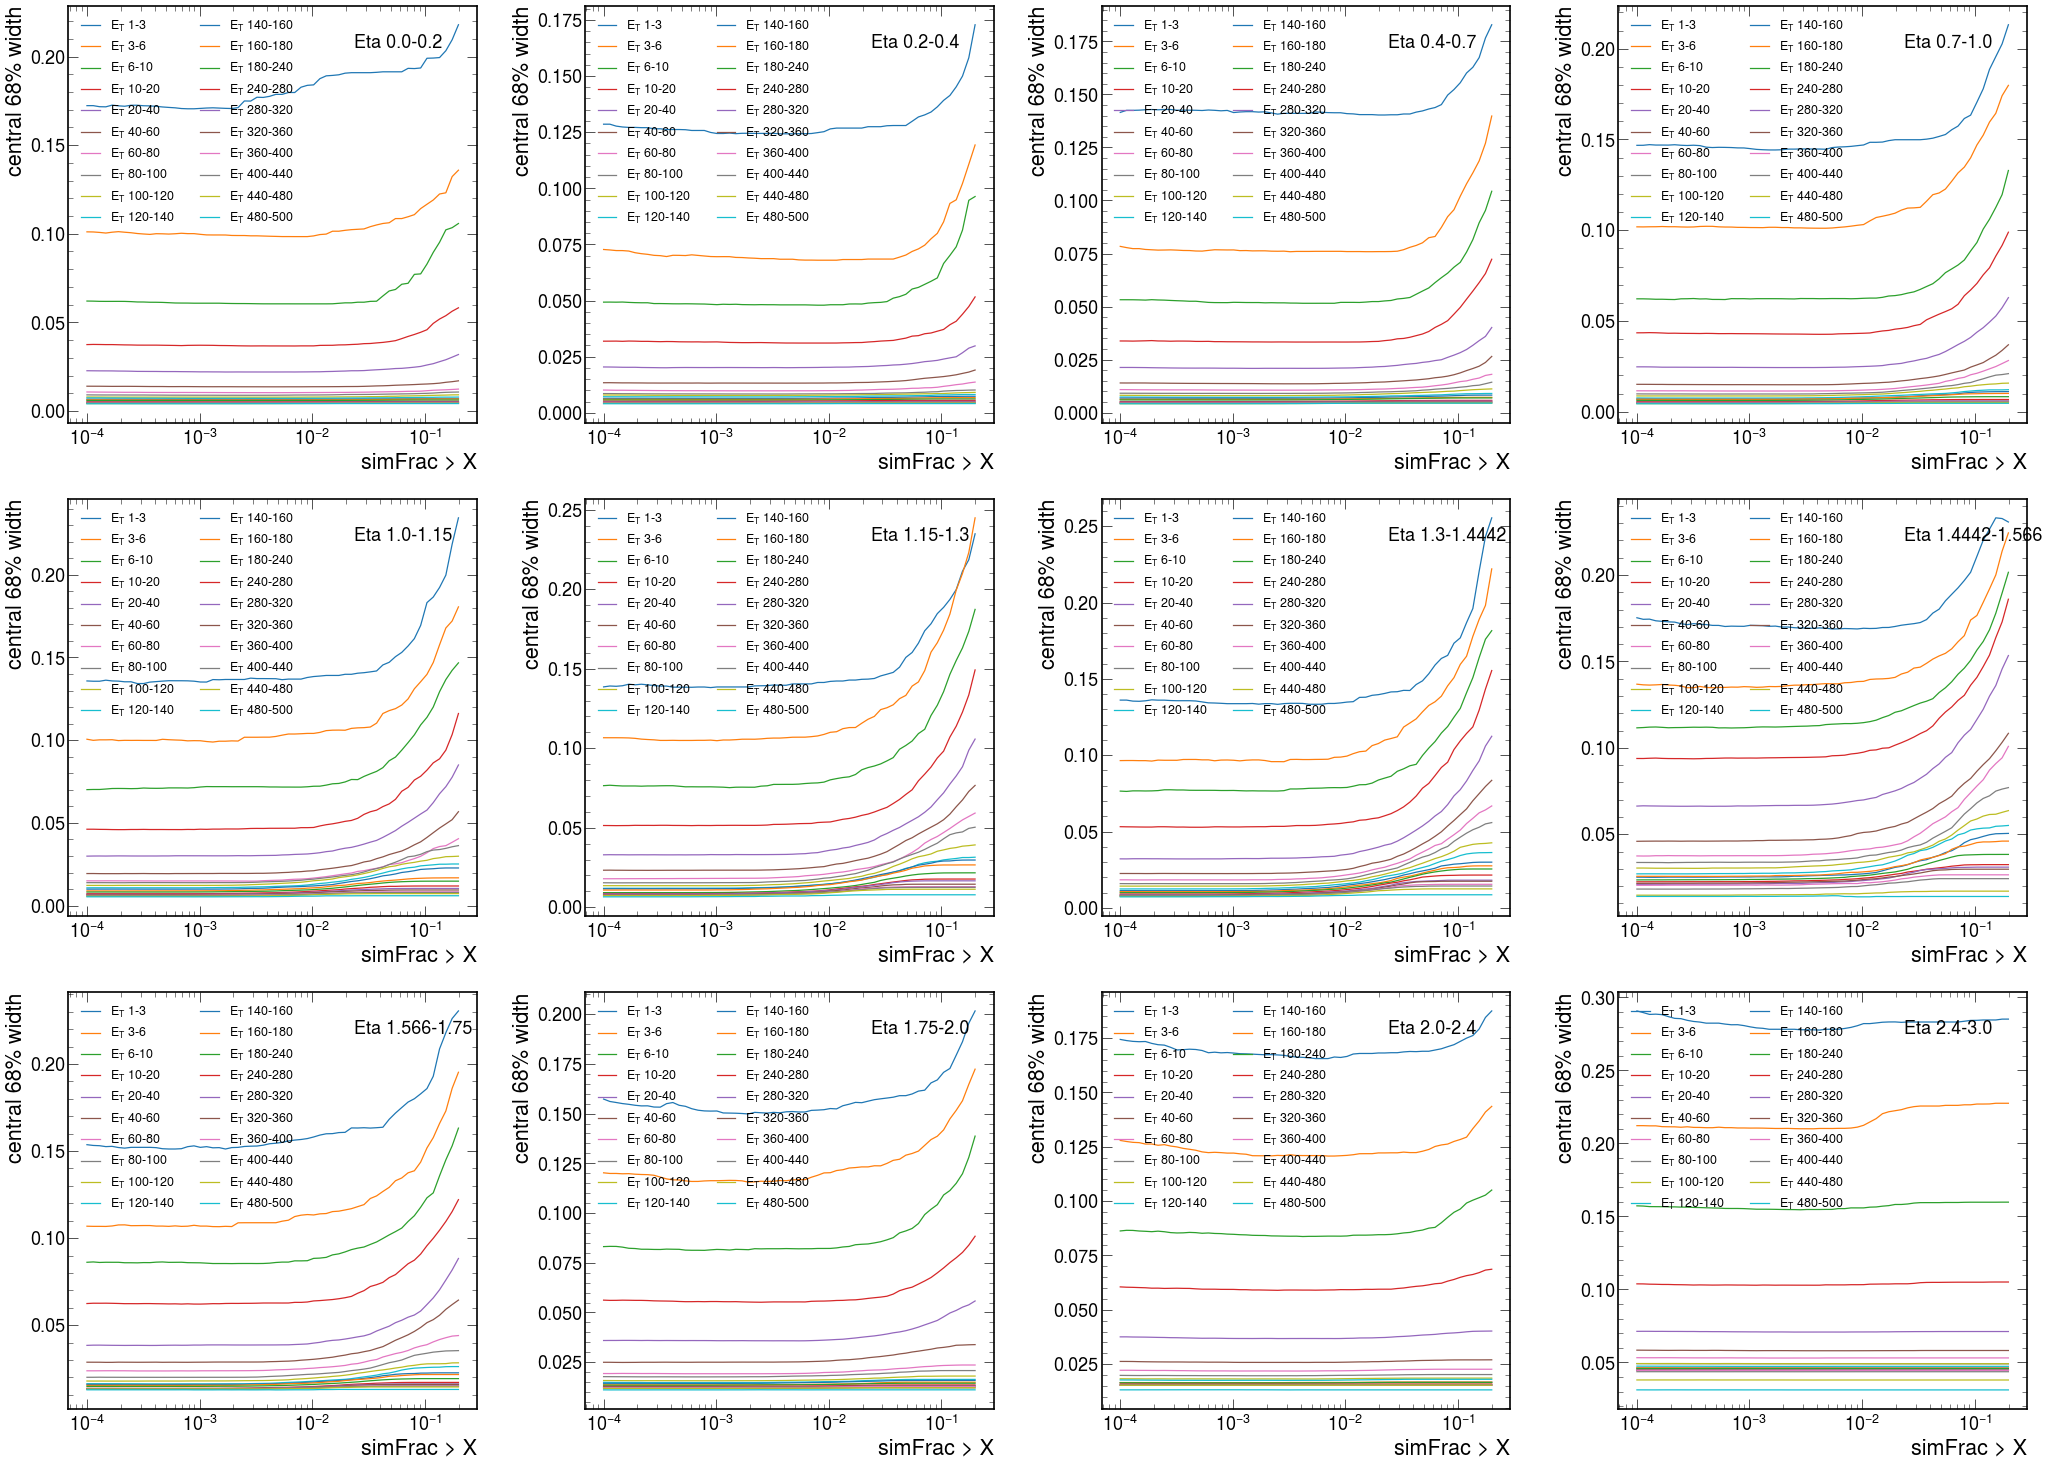

In [30]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.7,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Width_all.png')
f.savefig(outputdir+'/Width_all.pdf')

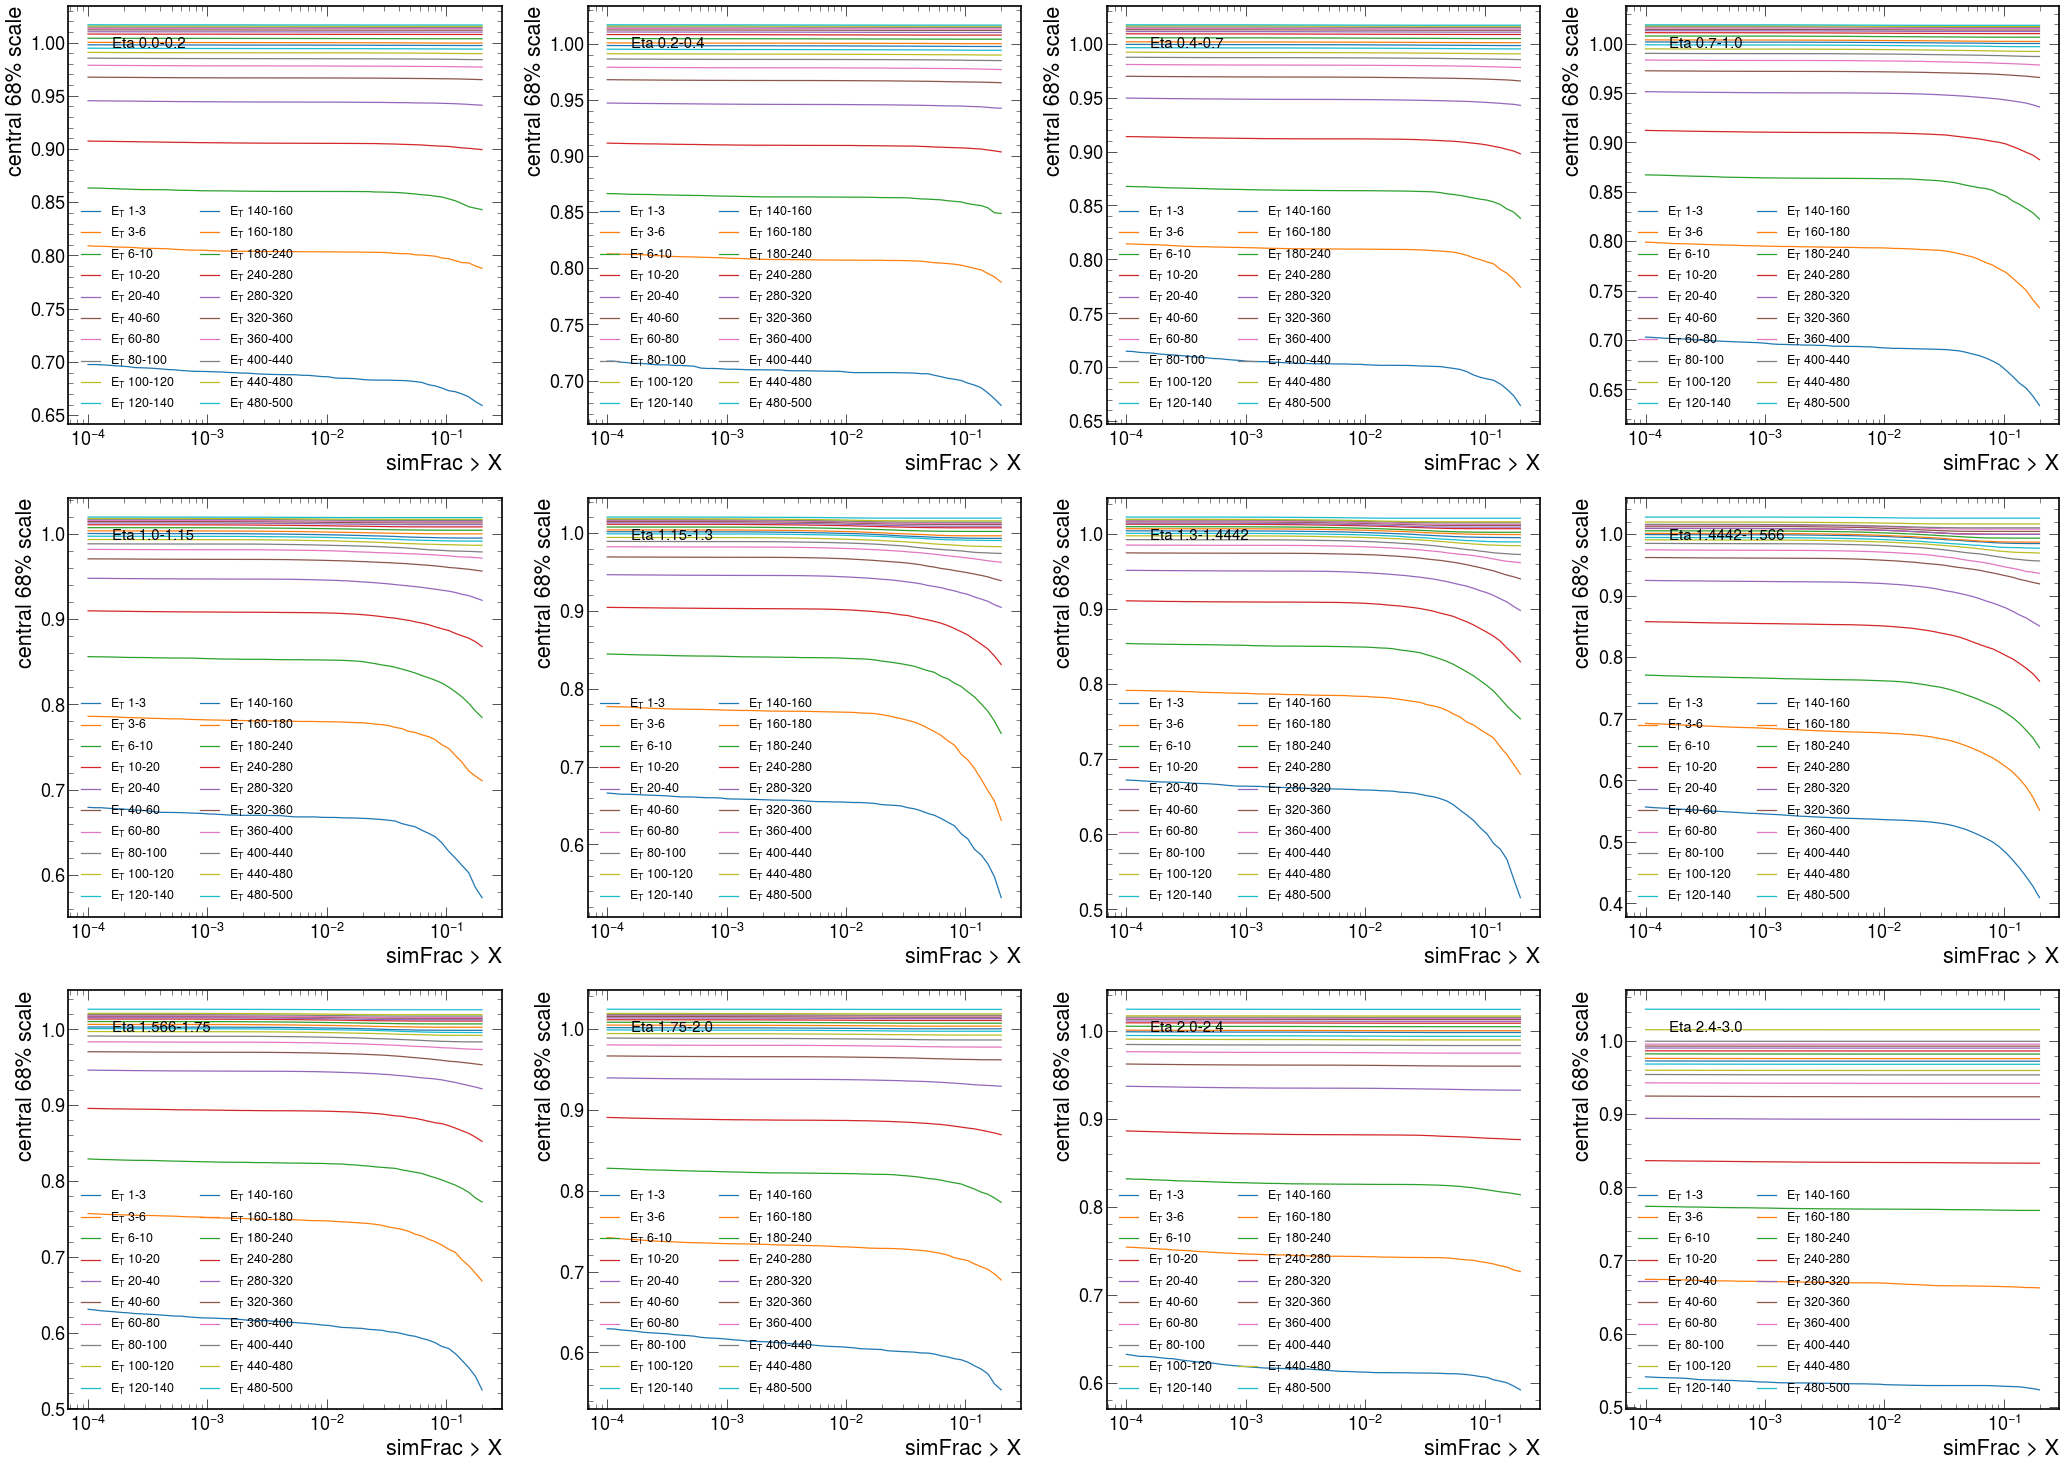

In [31]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.001, 0.05)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Scale_all.png')

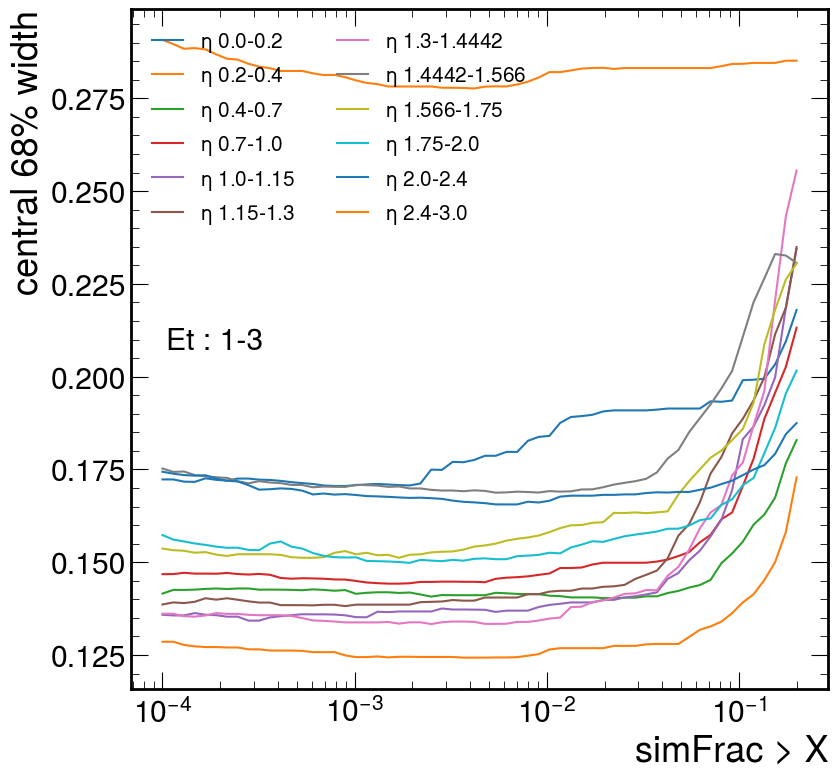

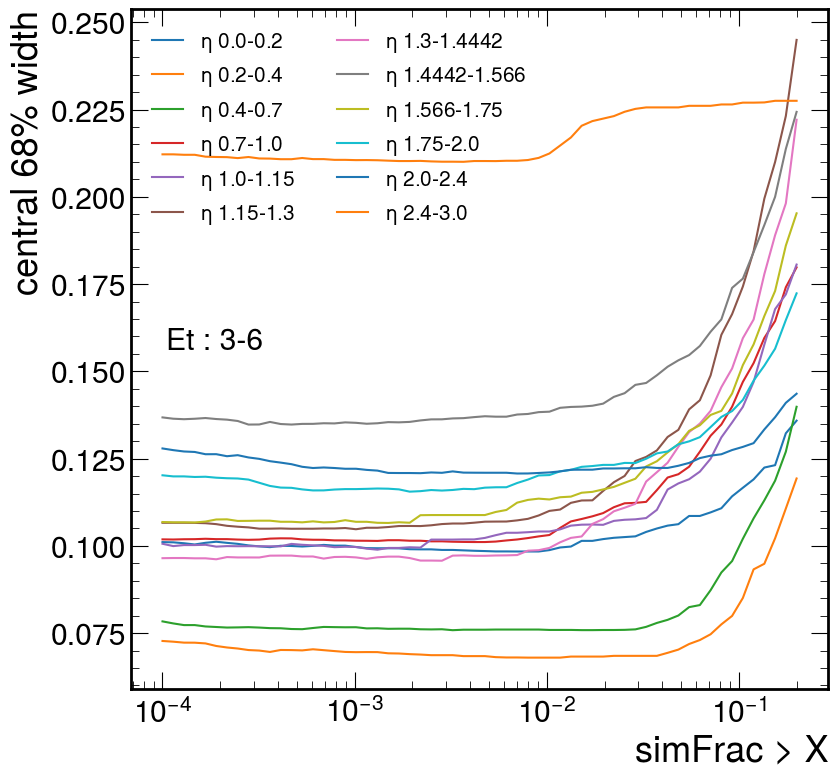

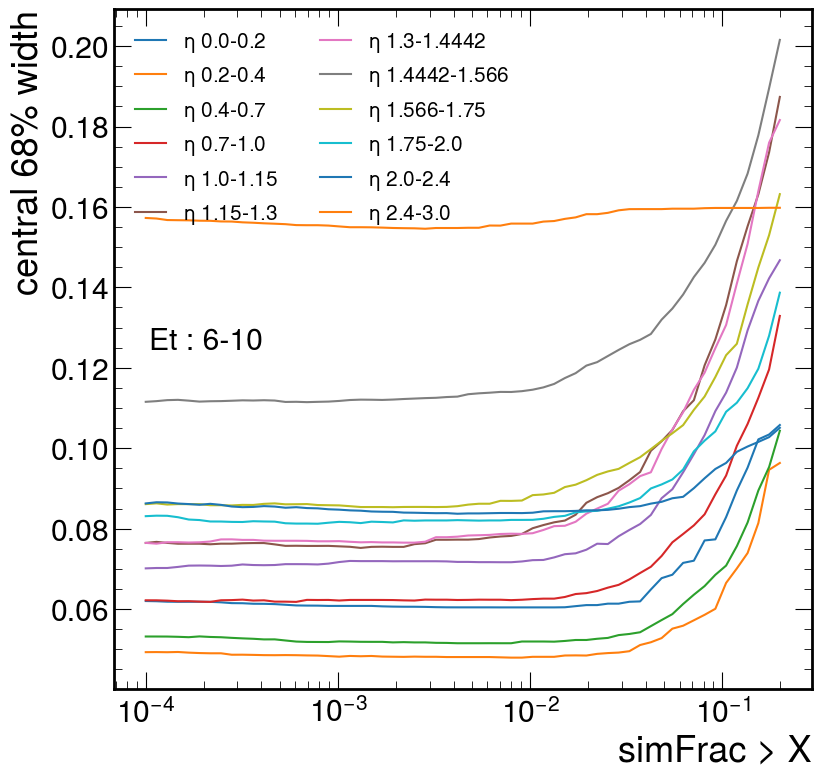

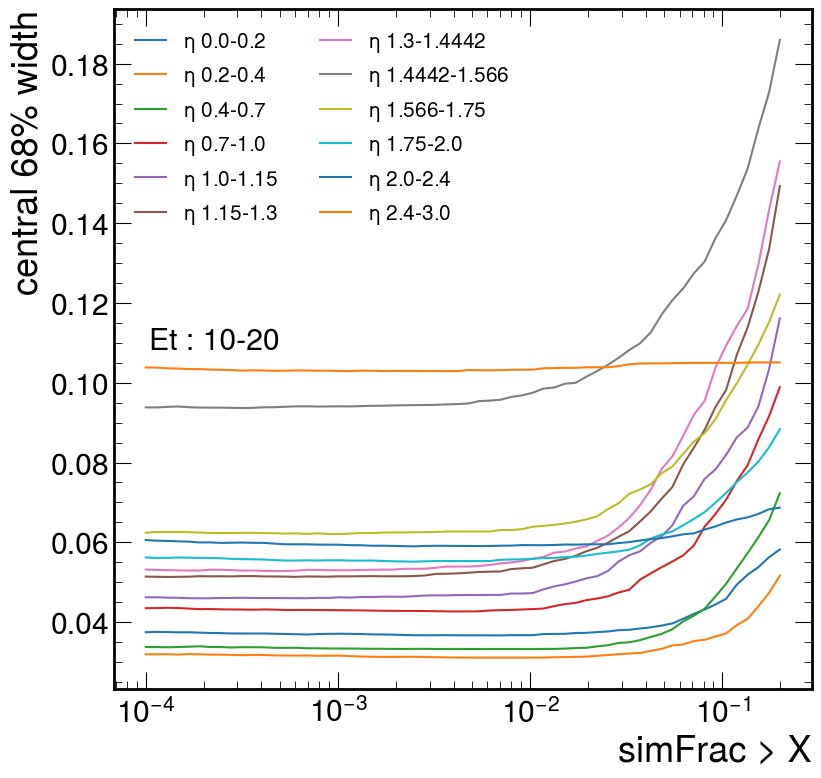

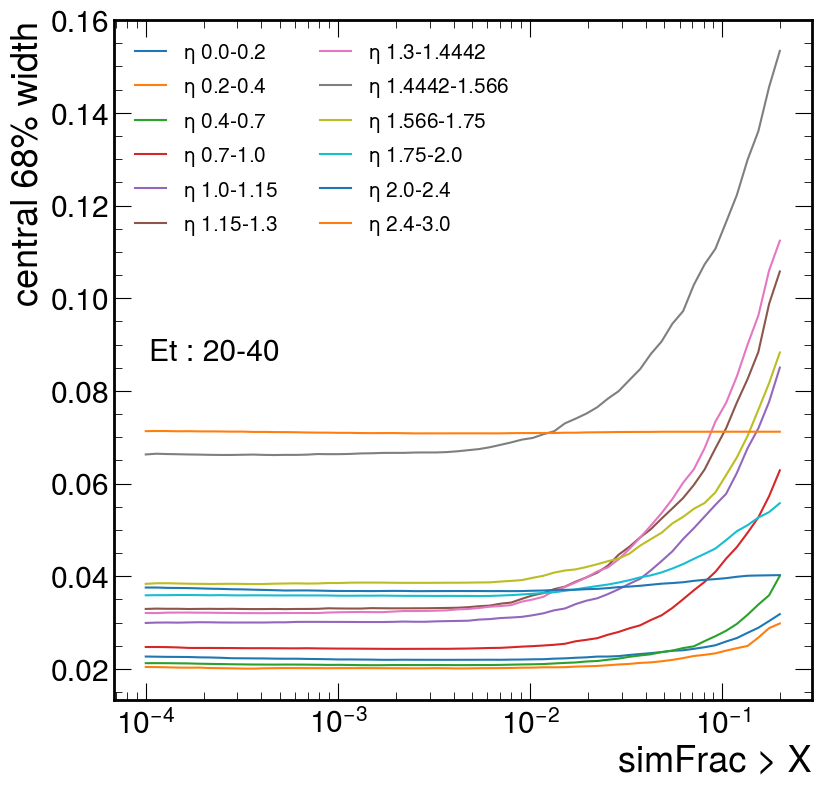

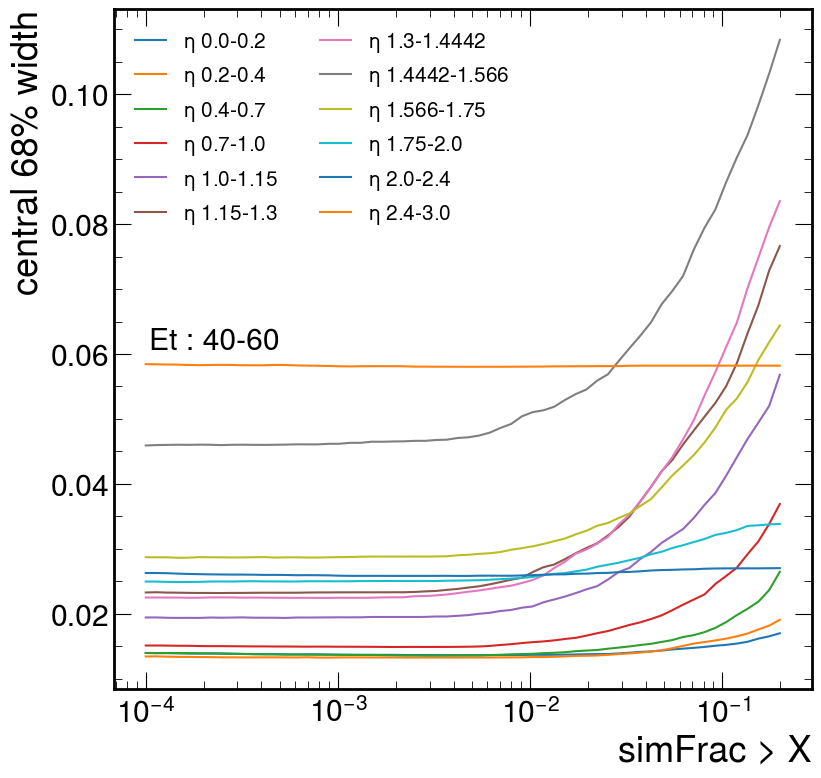

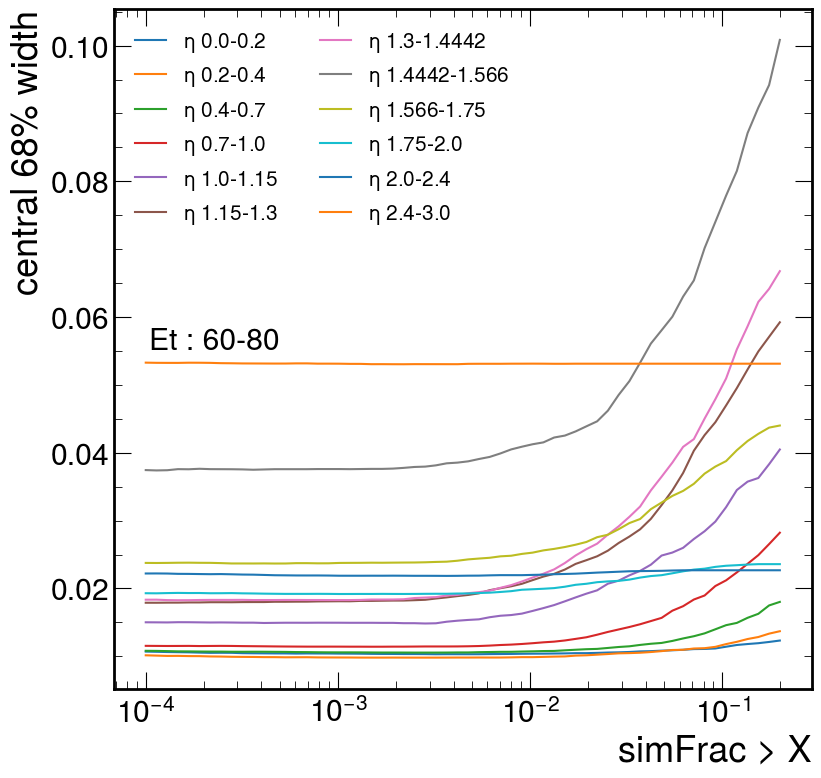

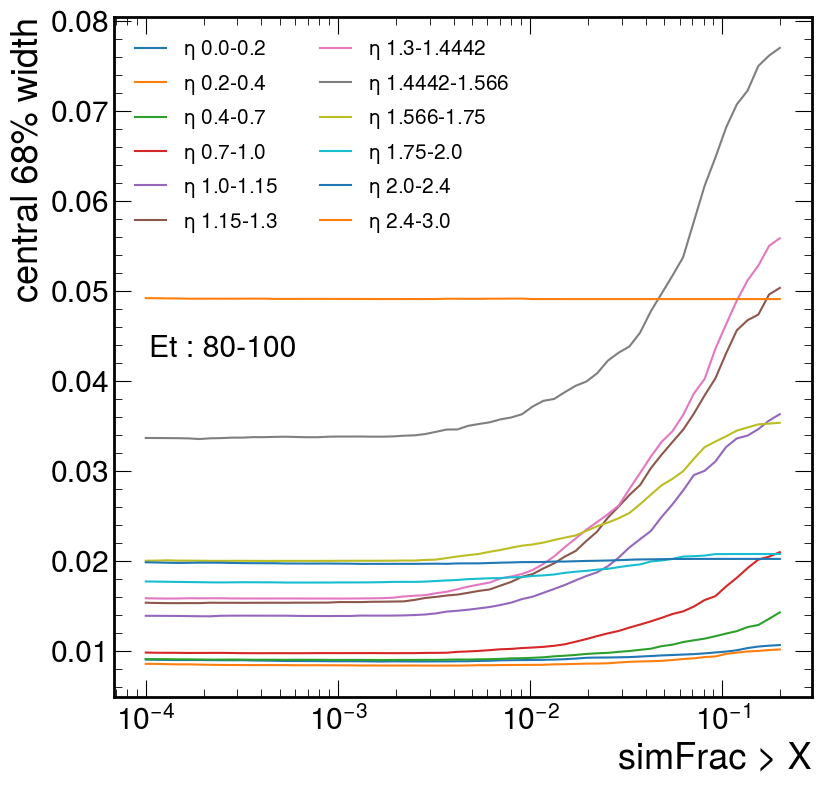

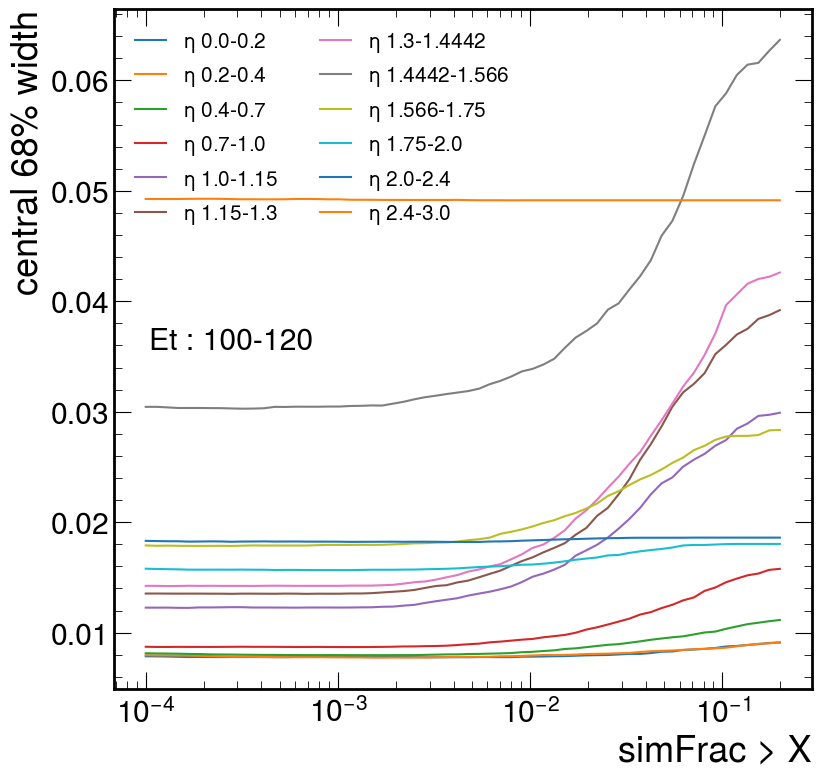

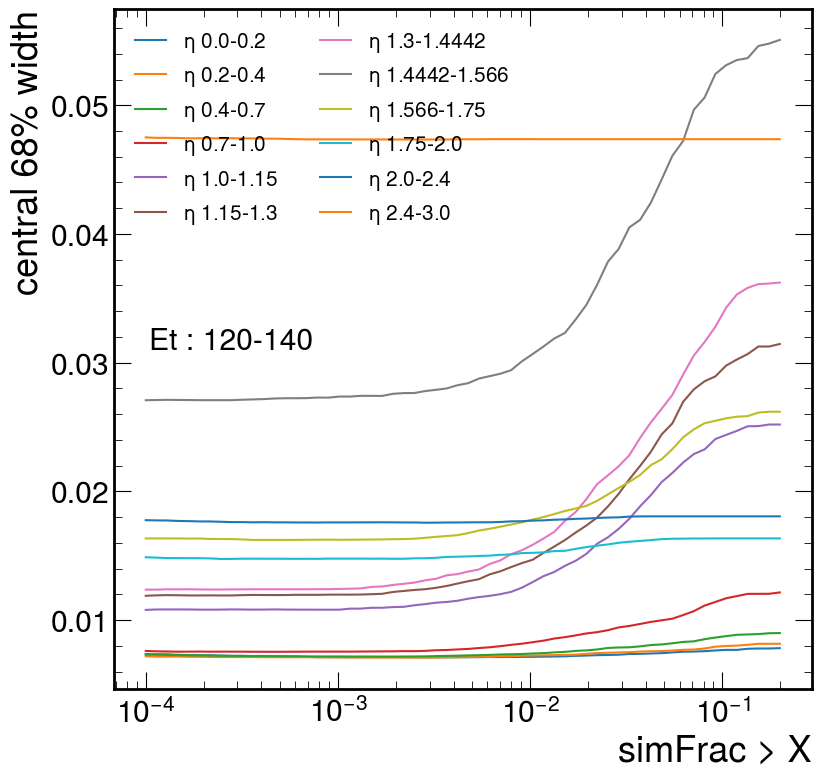

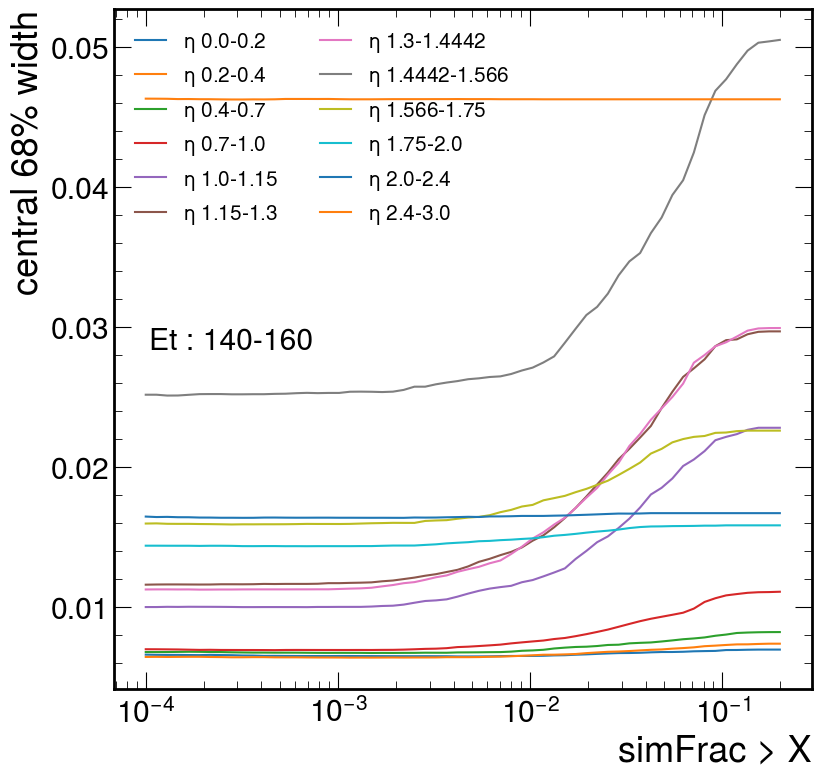

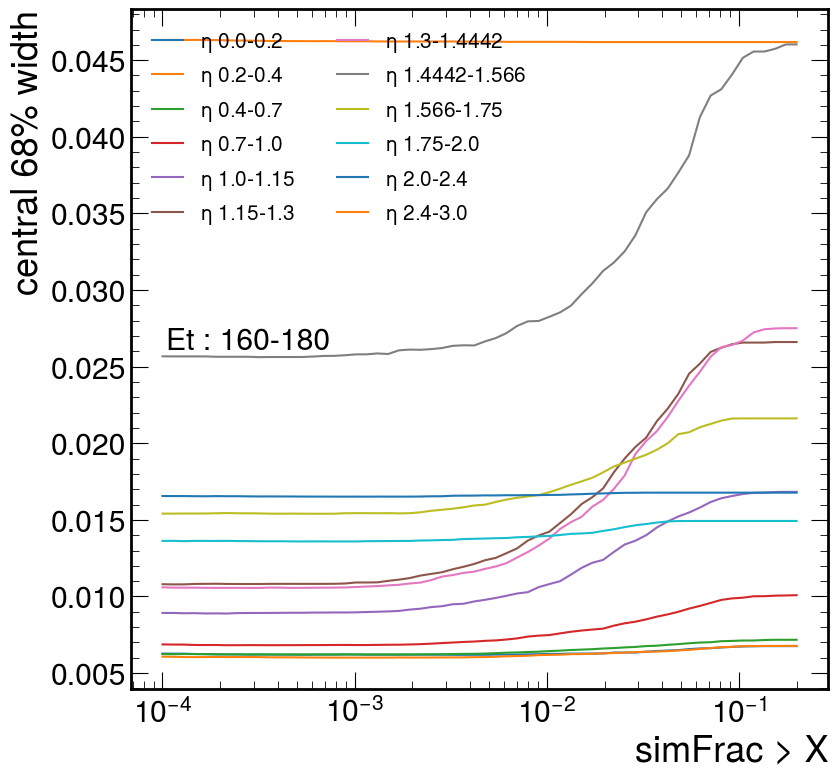

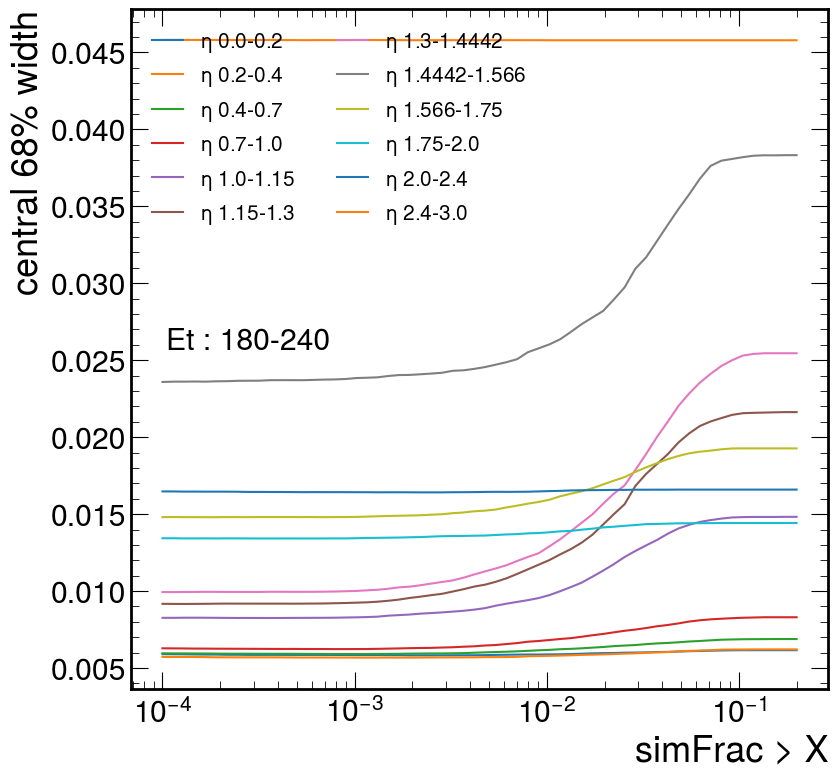

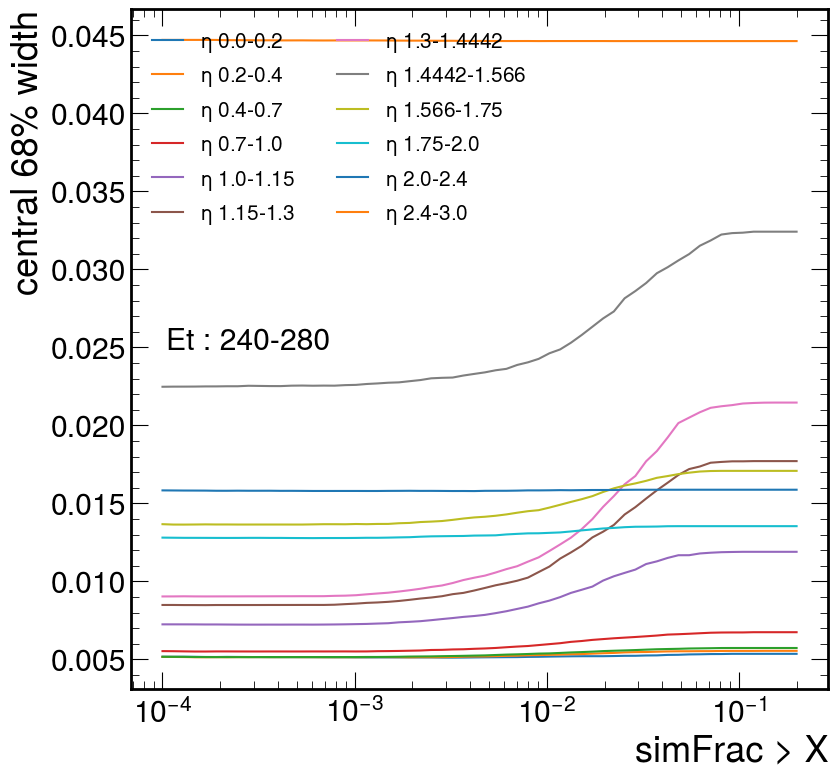

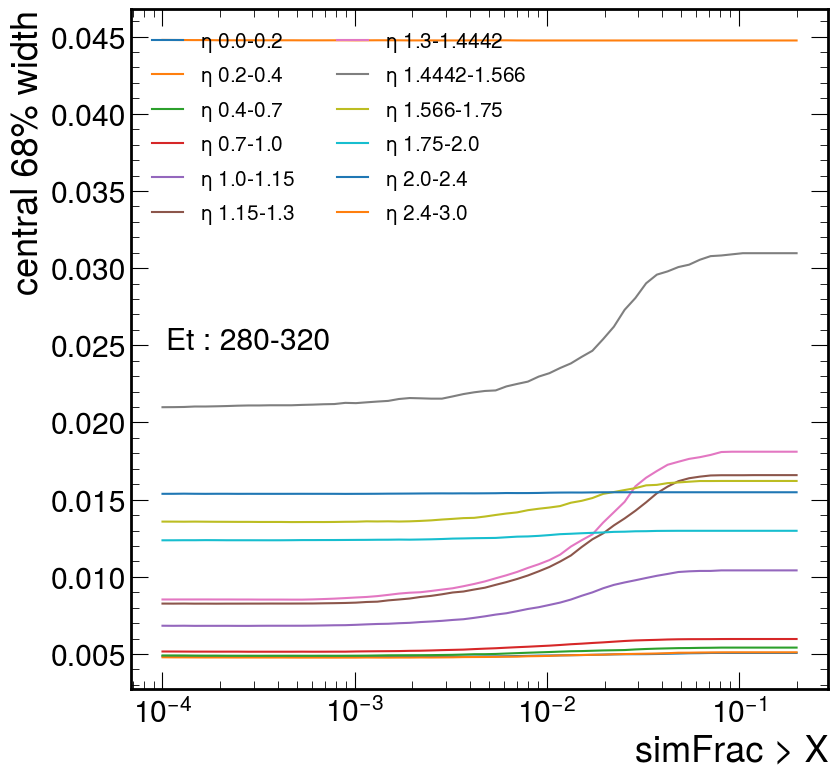

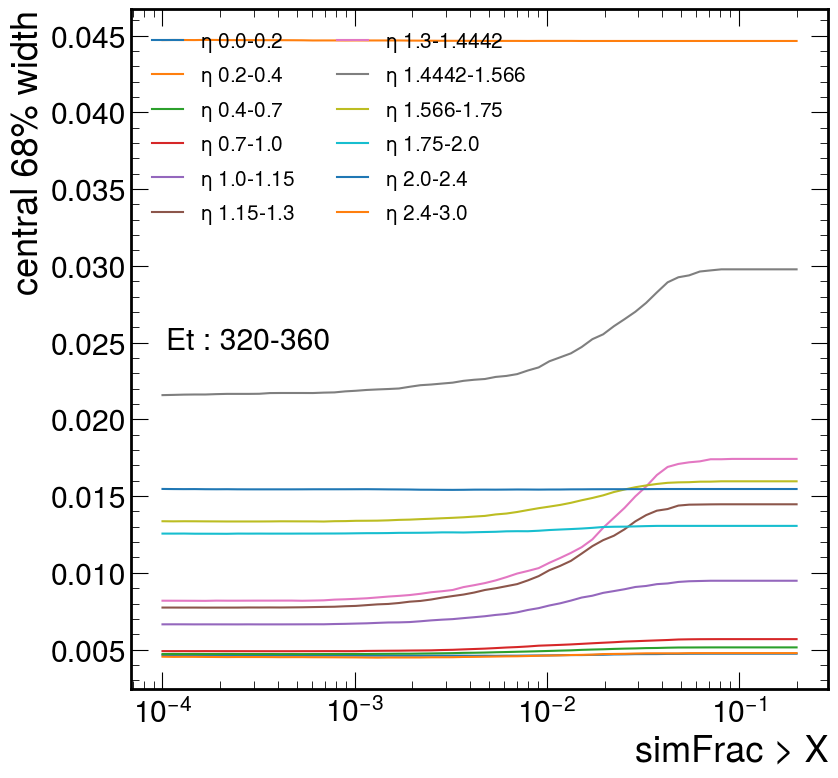

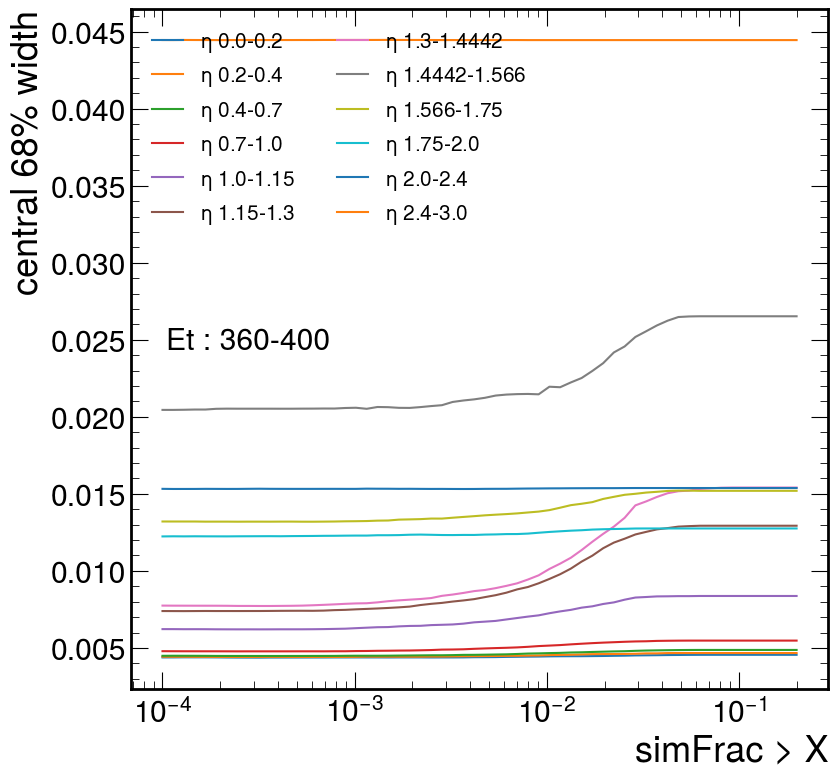

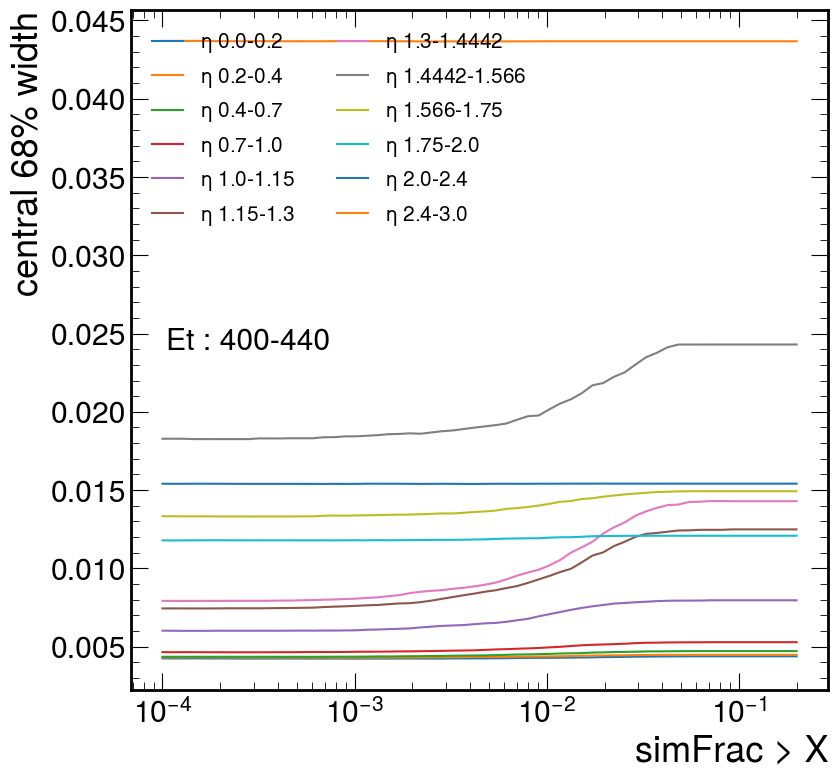

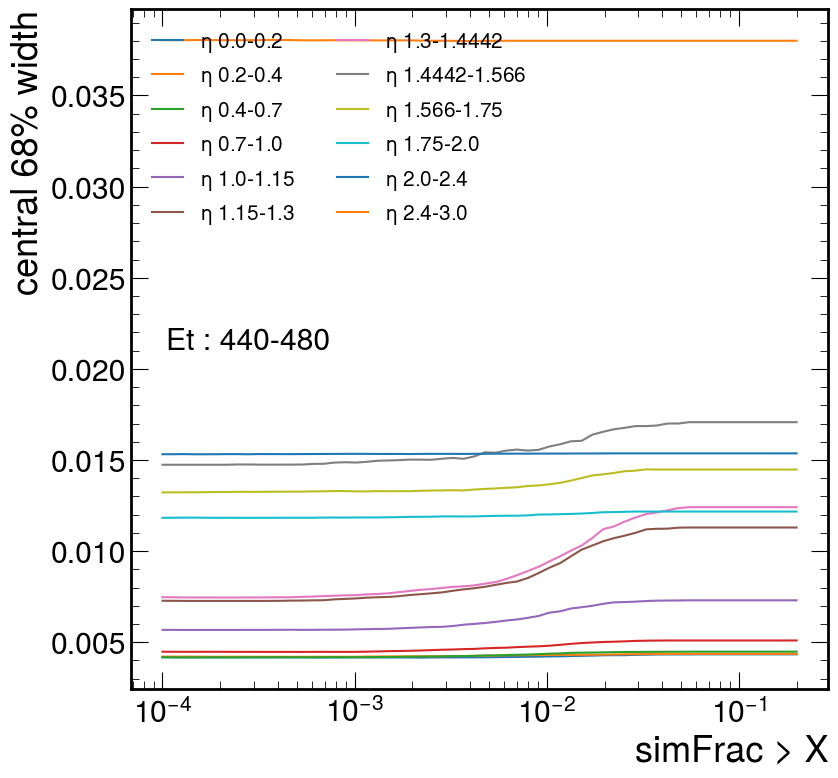

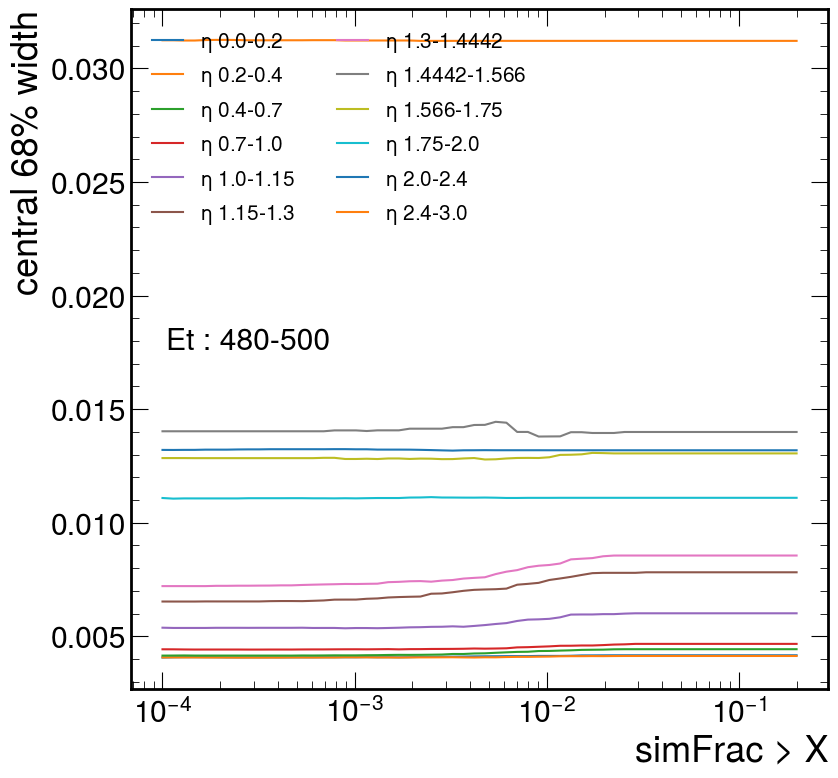

In [32]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Width_Et{}_{}.pdf'.format(ets[iet],ets[iet+1]))

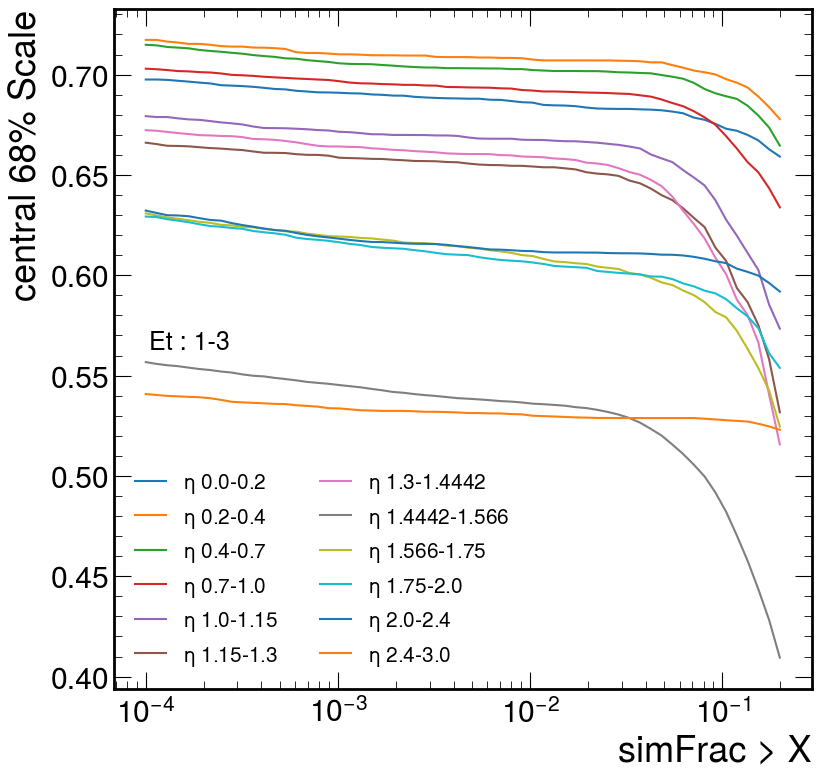

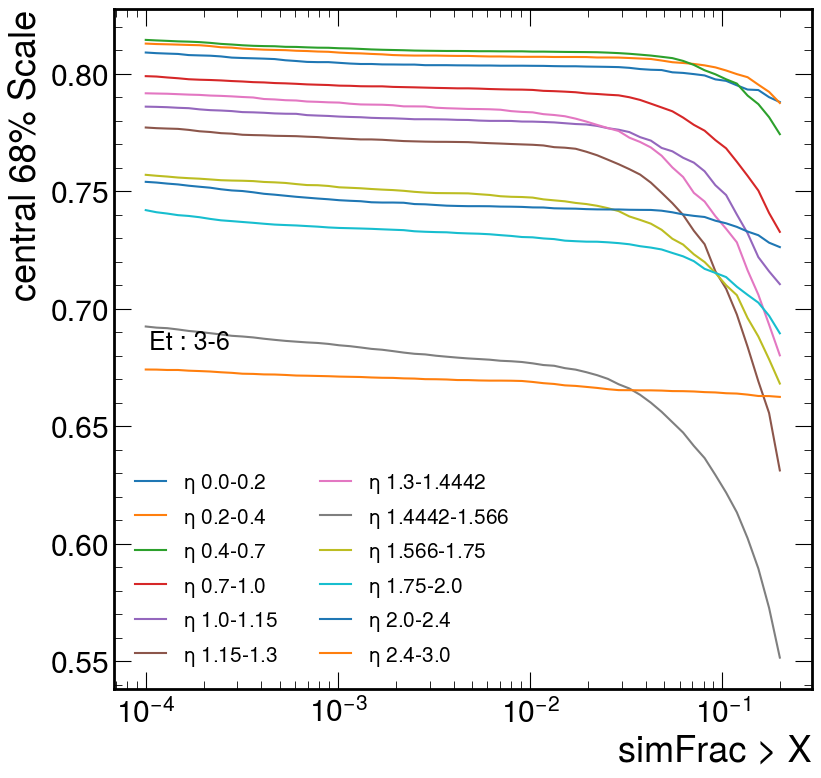

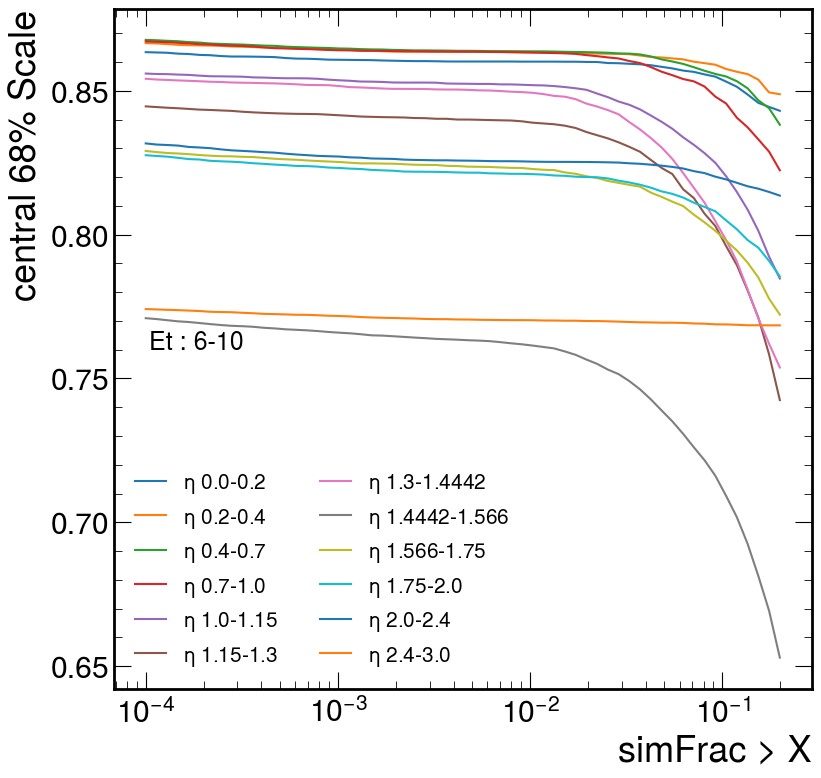

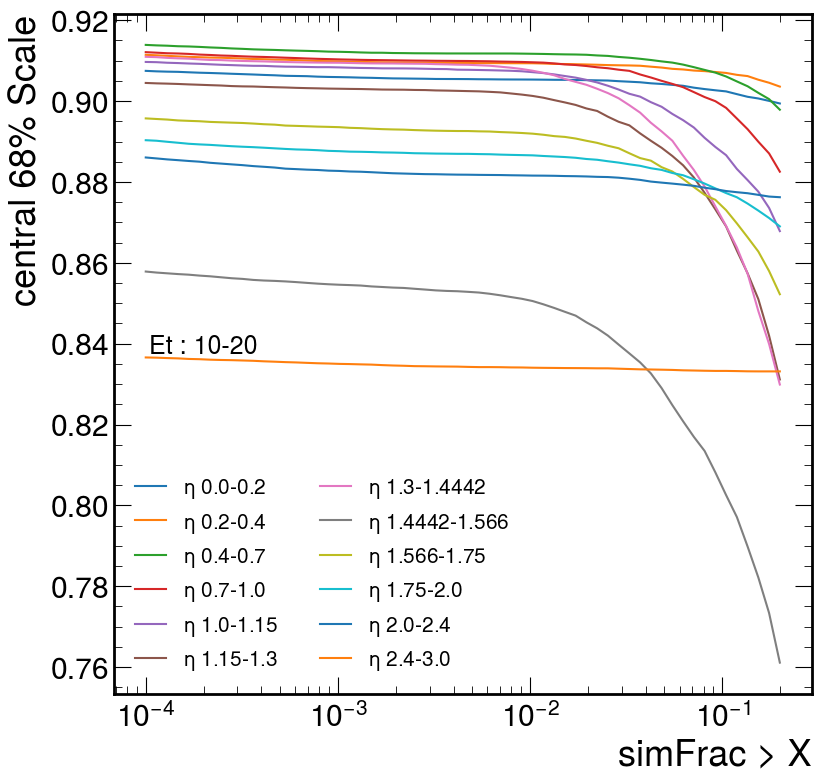

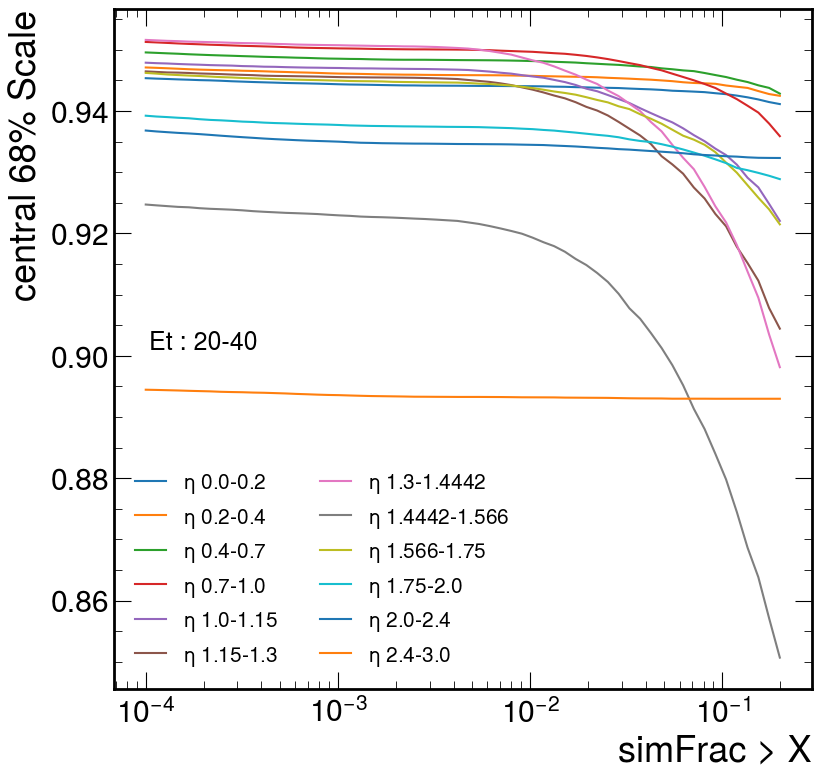

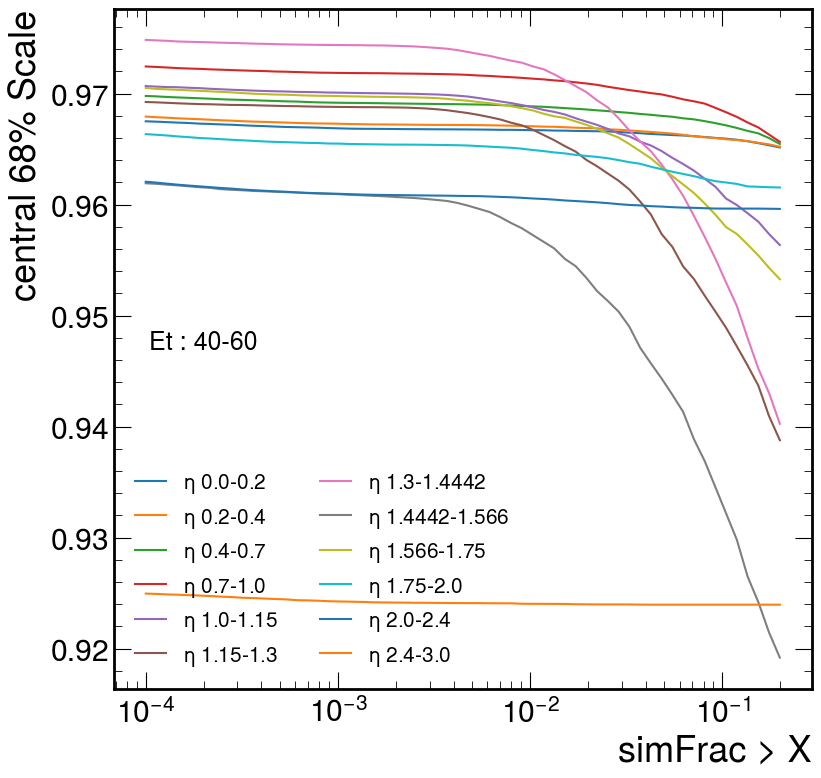

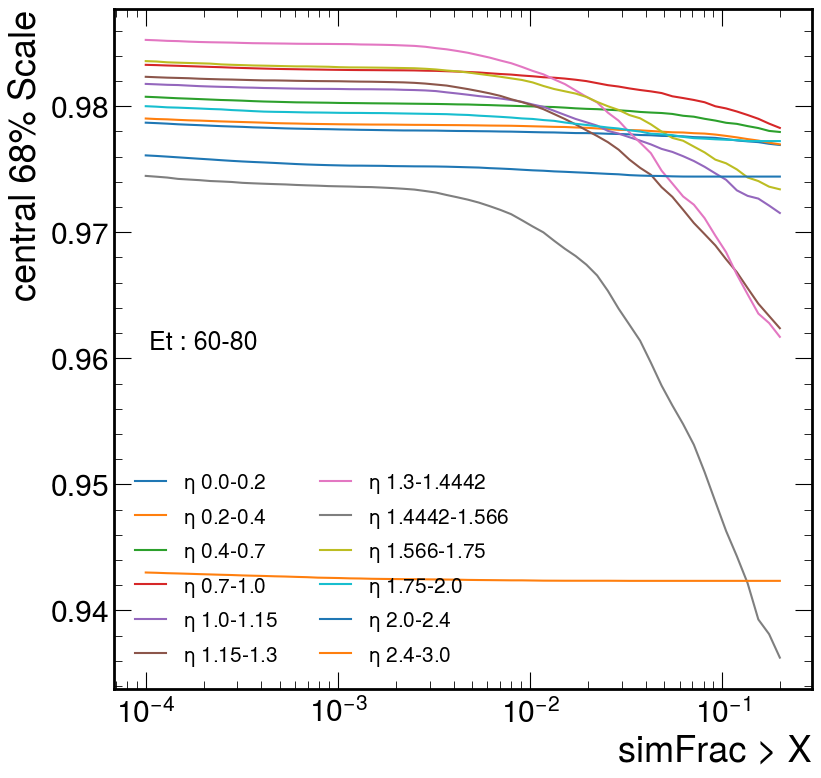

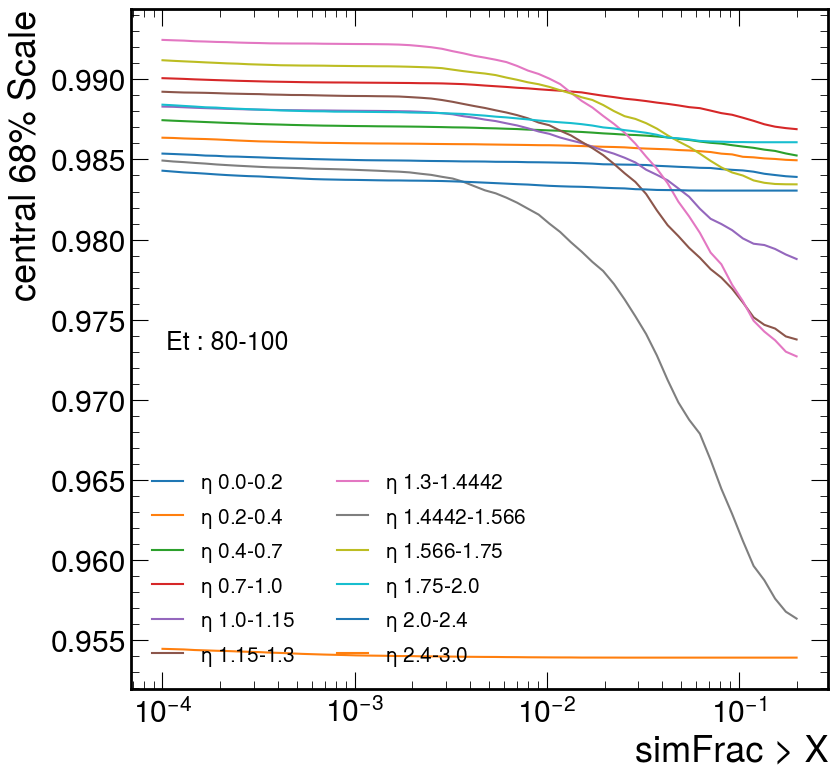

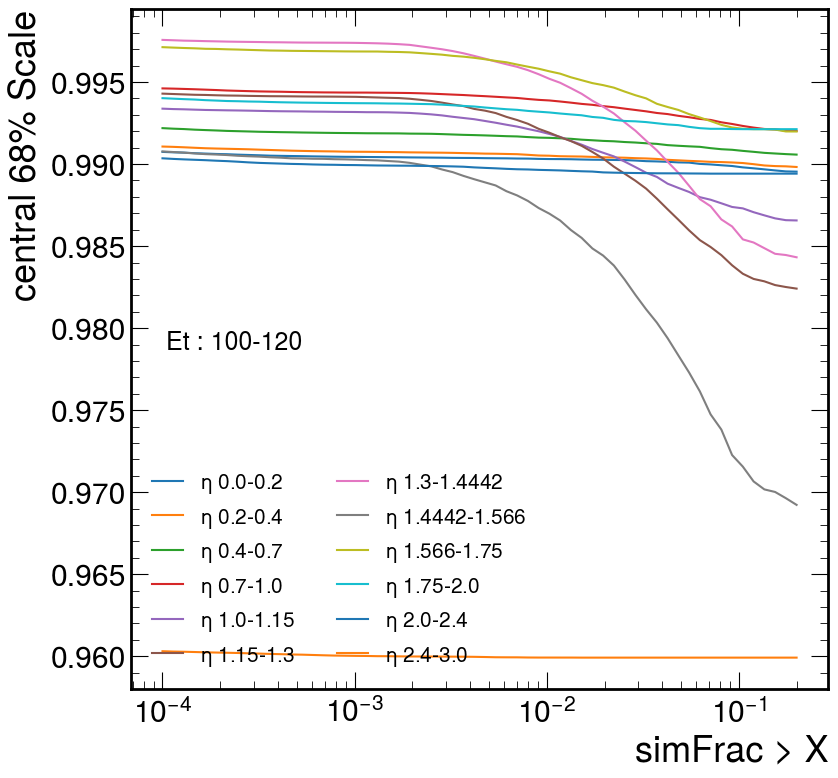

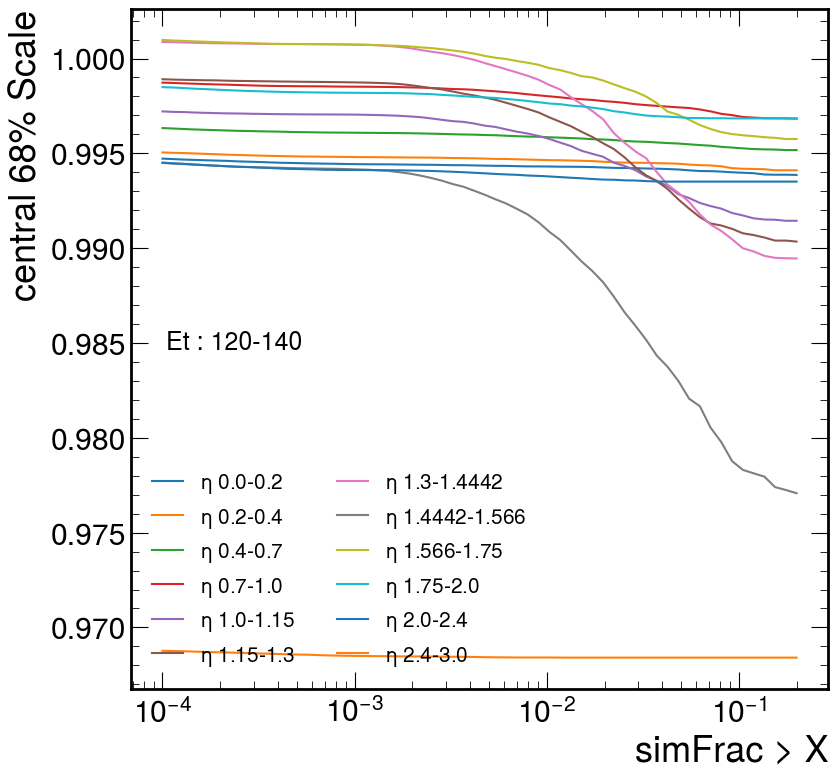

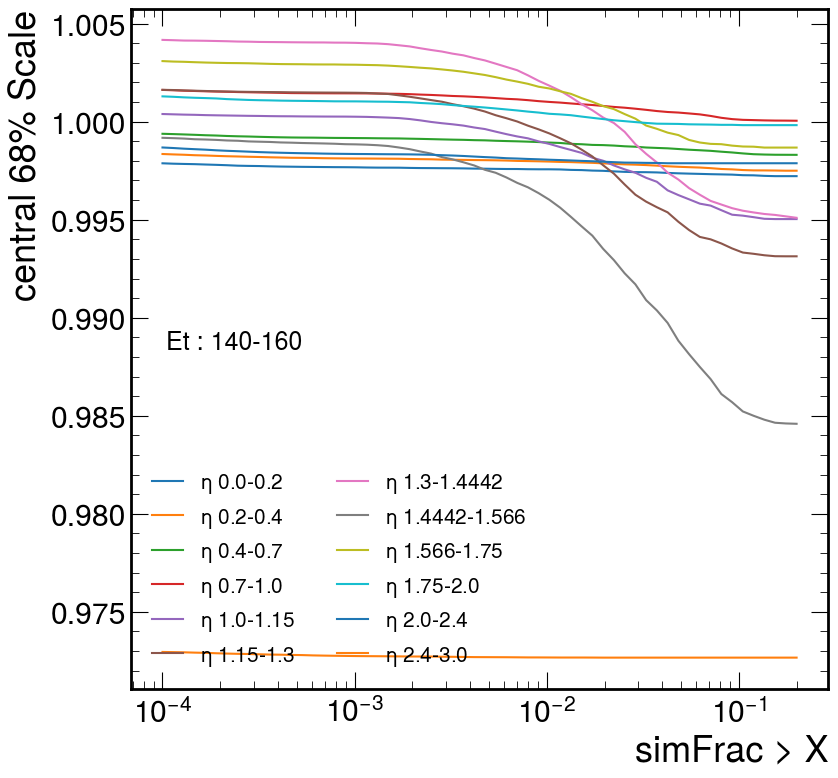

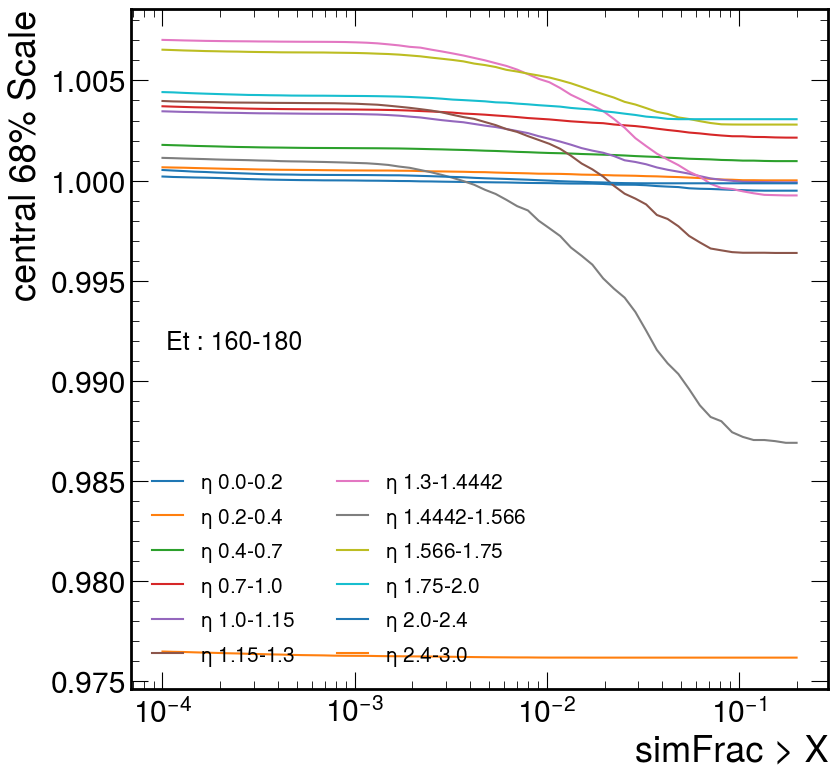

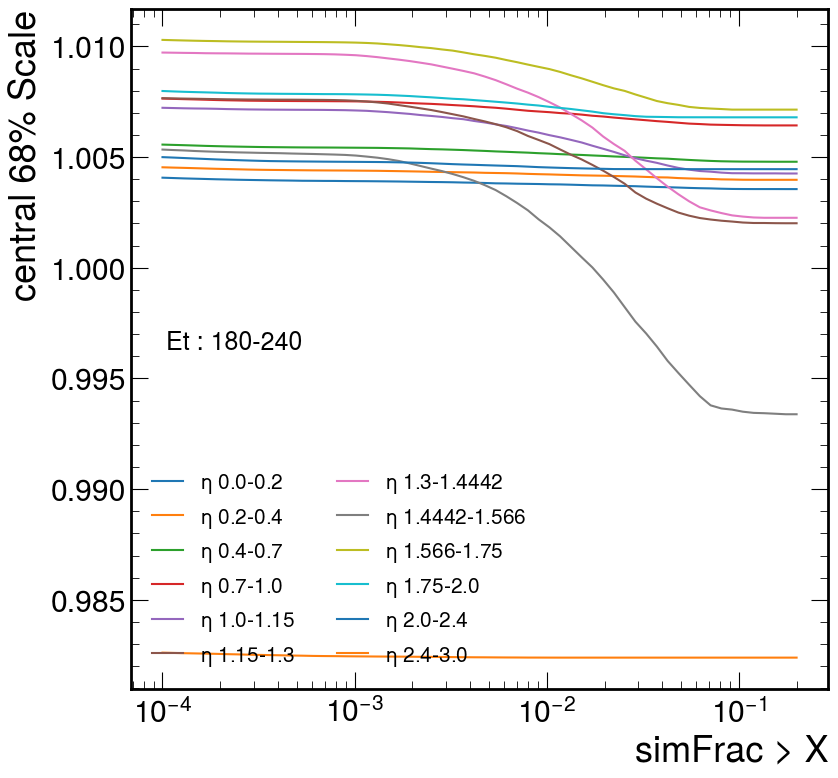

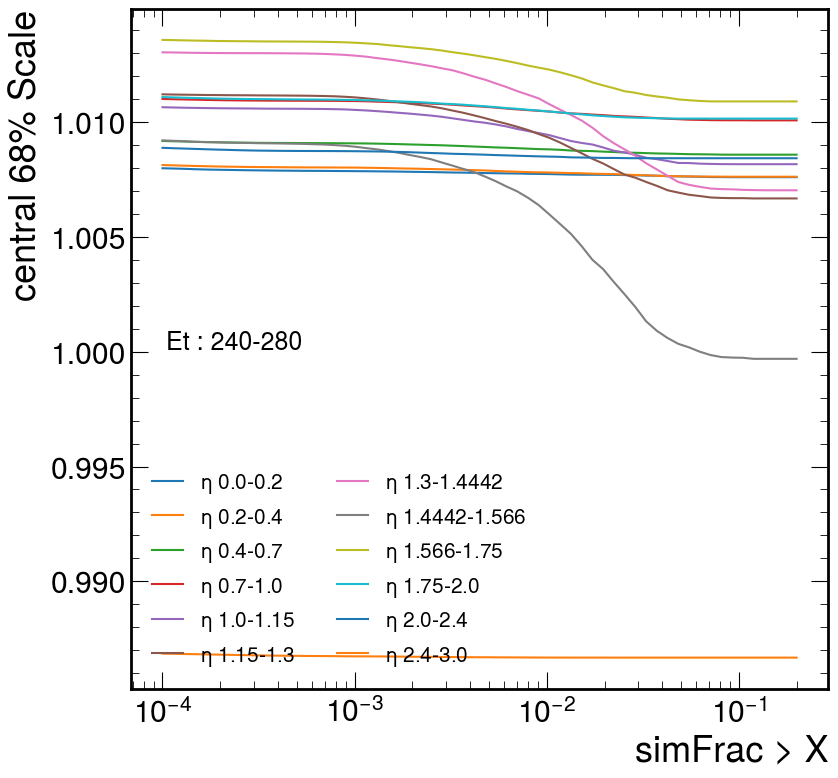

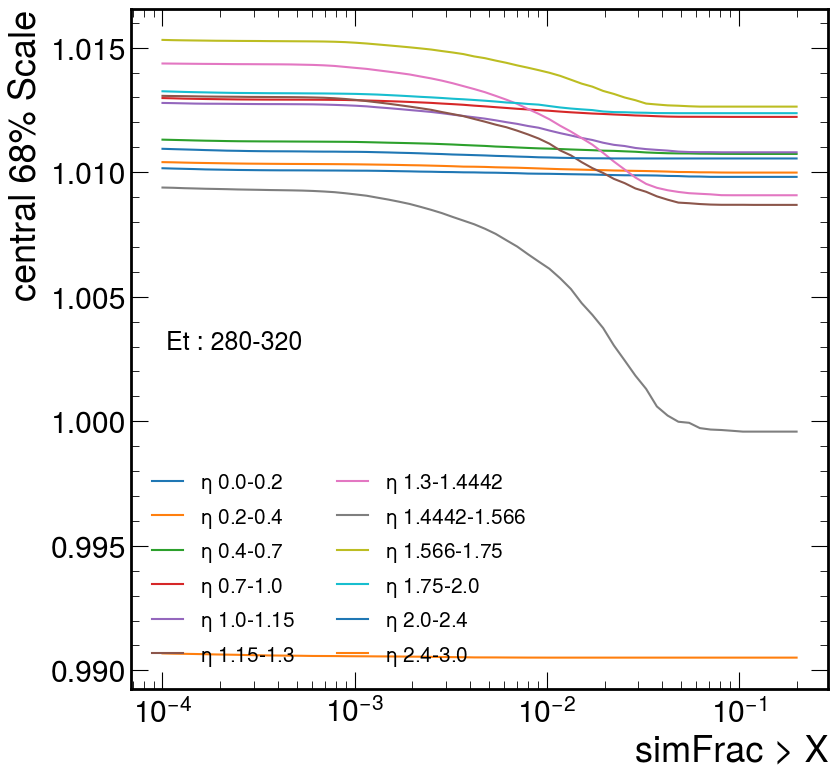

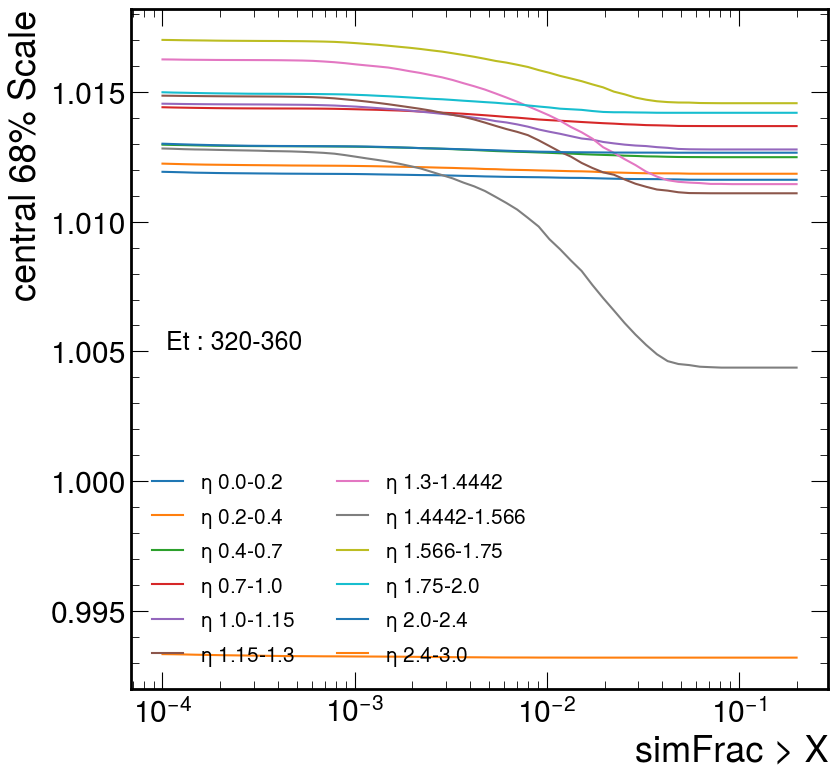

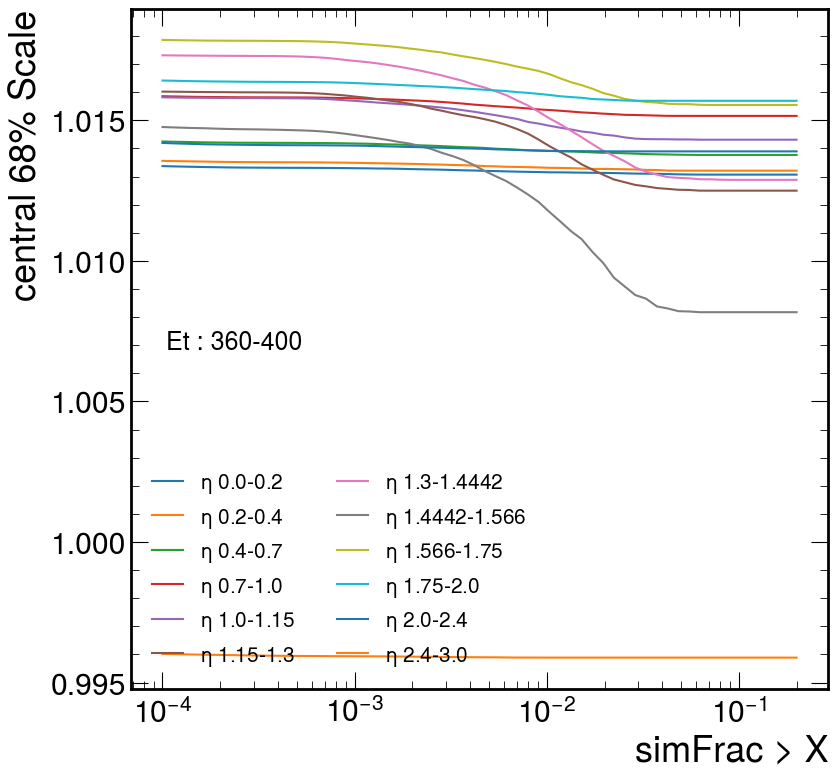

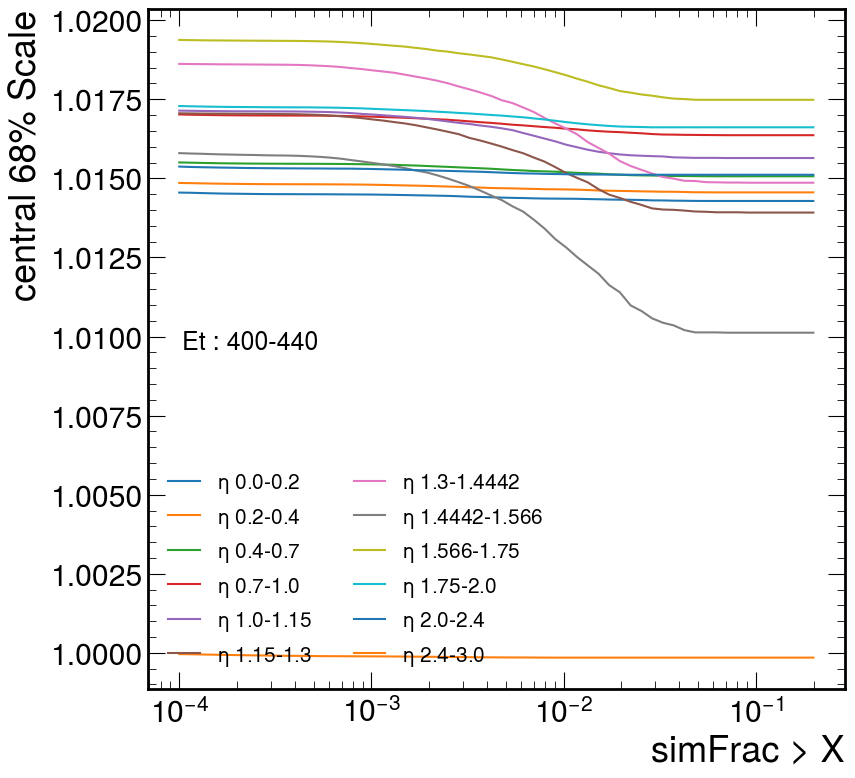

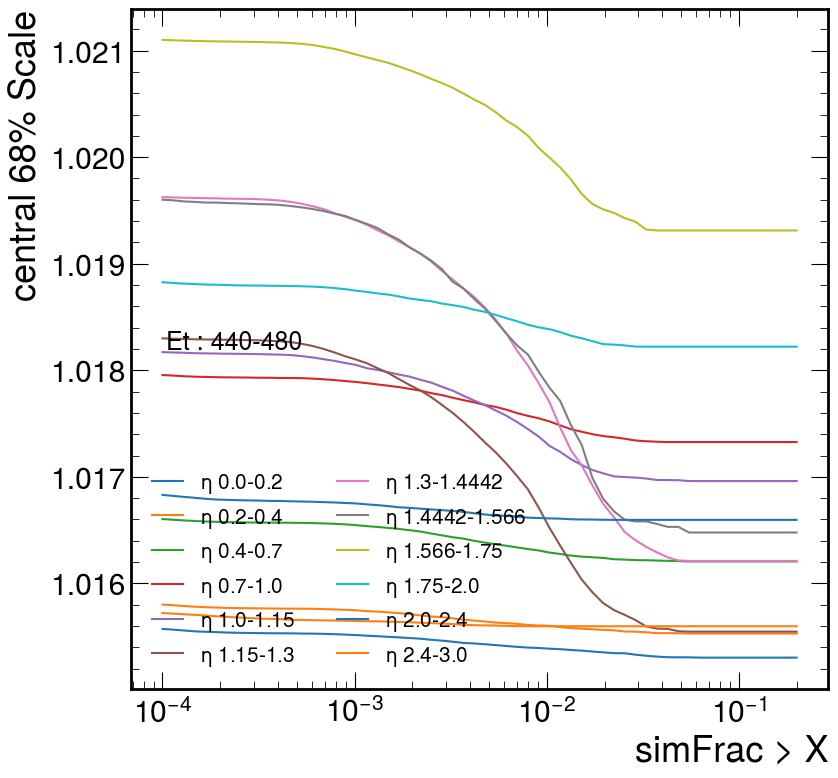

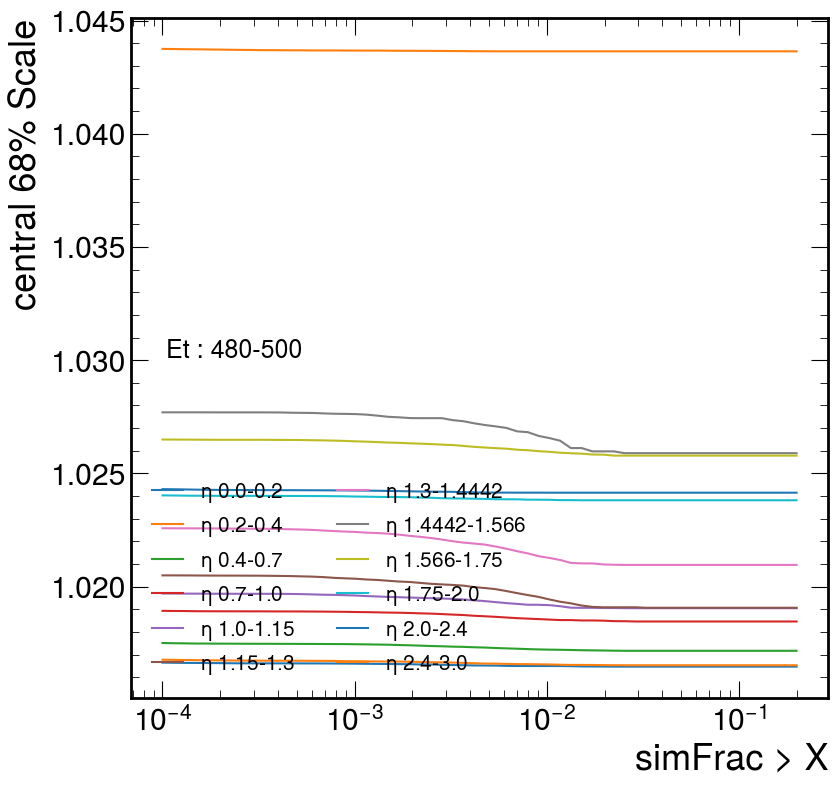

In [33]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% Scale")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Scale_{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Scale_{}_{}.pdf'.format(ets[iet],ets[iet+1]))

# Summary thresholds
Now we check which threshold corresponds to the best truth resolution in each eta/pt bin

In [3]:
etas = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0,2.4,3.0]
ets = [ 1,3,6,10] + list(range(20, 200, 20)) + list(range(240, 500, 40)) + [500]

In [34]:
def bin_analysis_summary(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"],
        "rel_err" : line["rel_err"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis_summary)
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

In [35]:
simfrac_thr = a
simfrac_thr.to_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";", index=False)

In [4]:
#loading
simfrac_thr = pd.read_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";")

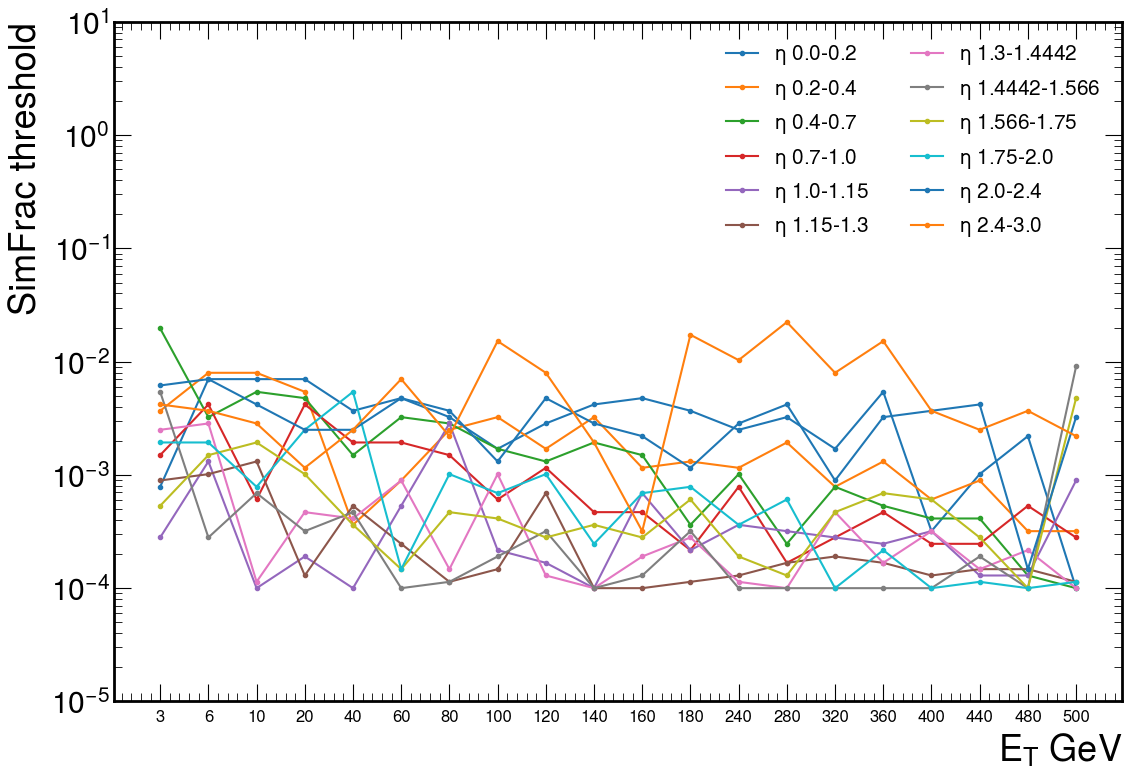

In [5]:
f, ax = plt.subplots(1,1, figsize=(13,9), dpi=100)

for i in range(len(etas)-1): 
    b = simfrac_thr[simfrac_thr.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker=".")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
ax.set_ylim(1e-5, 10)
ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]], fontsize=12)

f.savefig(outputdir+'/Scale_all_min.png')

/tmp/ipykernel_1516/1549900336.py:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)


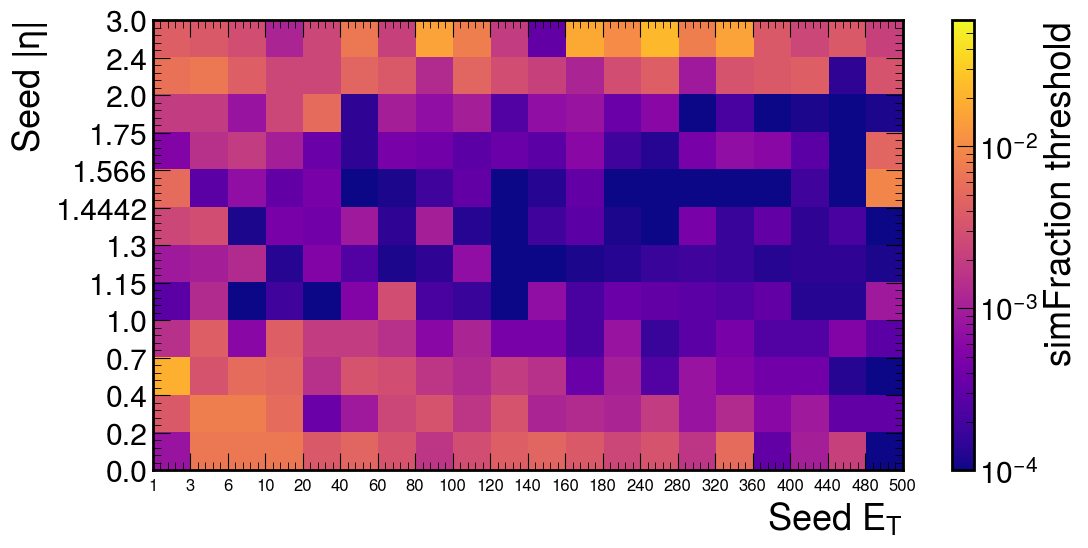

In [6]:
f = plt.figure(figsize=(12,6), dpi=100)
c = simfrac_thr.thr.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)
plt.colorbar(label="simFraction threshold")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets], fontsize=12)
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map.png")
f.savefig(outputdir+ "/simfraction_map.pdf")

/tmp/ipykernel_994/3861775819.py:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)


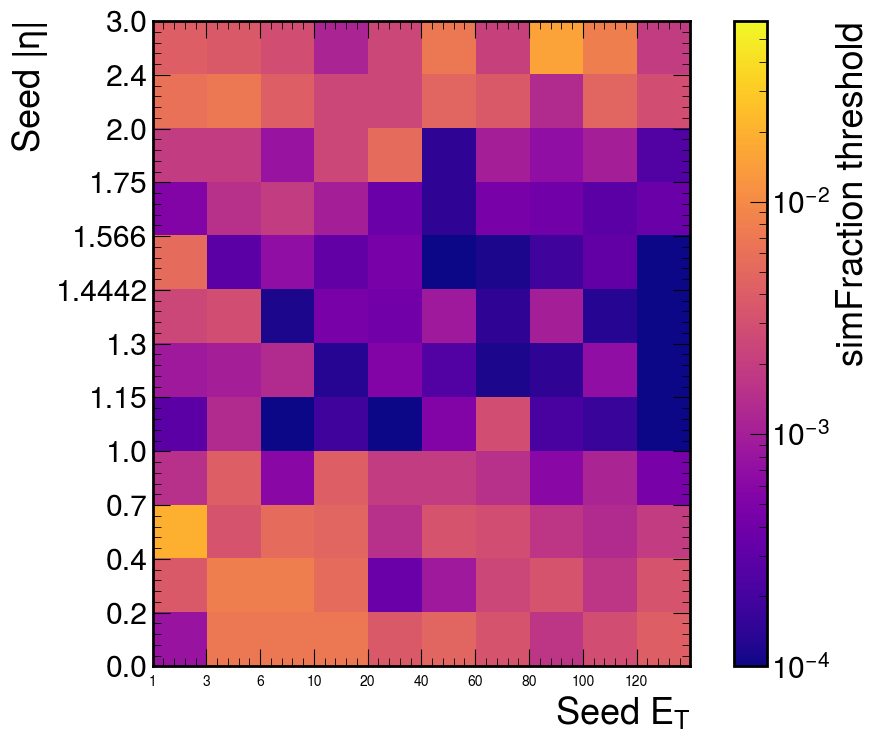

In [39]:
f = plt.figure(figsize=(10,8), dpi=100)
c = simfrac_thr.thr.values.reshape((len(ets)-1, len(etas)-1))[0:10,:]
plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)
plt.colorbar(label="simFraction threshold")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets[0:10]))-0.5, [ "{}".format(e) for e in ets[0:10]], fontsize=10)
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_zoom.png")
f.savefig(outputdir+ "/simfraction_map_zoom.pdf")

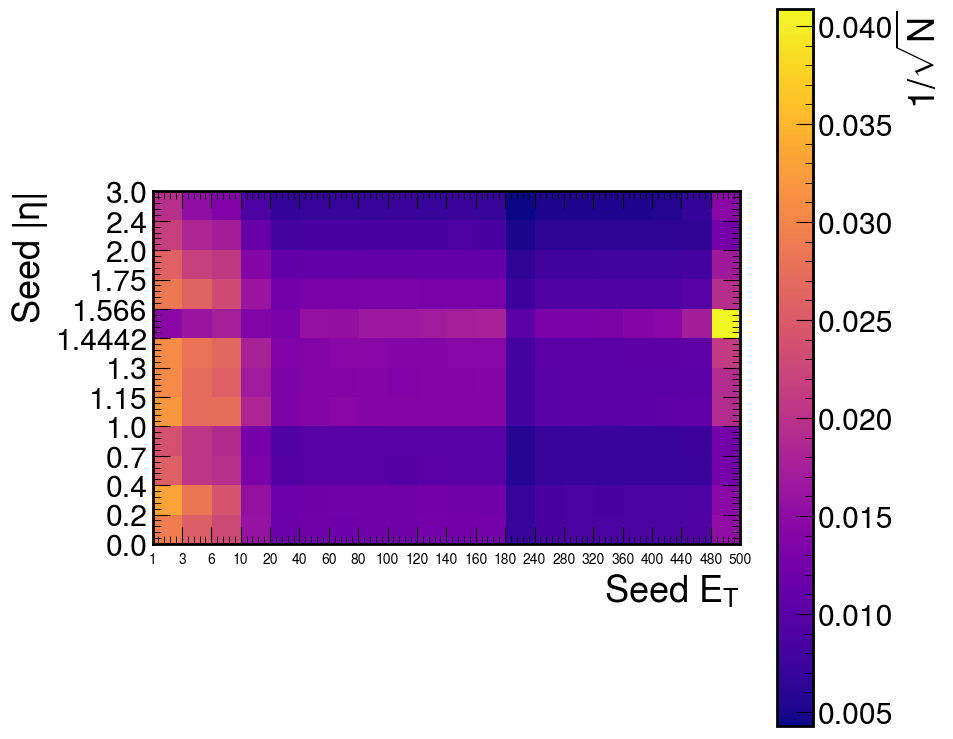

In [40]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.rel_err.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="$1 / \sqrt{N}$")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets],fontsize=10)
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_relerr.png")

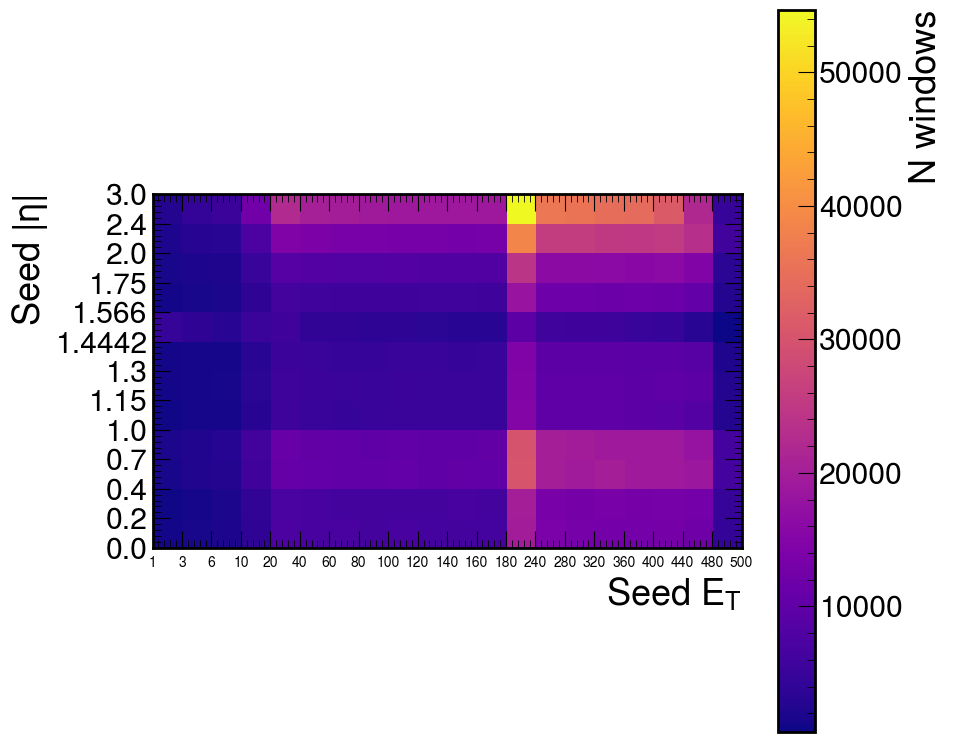

In [41]:
f = plt.figure(figsize=(10,8), dpi=100)
c = np.square((1/ a.rel_err).values).reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="N windows")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets], fontsize=10)
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_Nwindows.png")

# Export to correctionlib

In [7]:
 # Exporting it to correctionlib
import correctionlib, rich
import correctionlib.convert
import hist

h_weight = hist.Hist(
            hist.axis.Variable(ets, name="seed_et"),
            hist.axis.Variable(etas, name="seed_eta"),
            storage="double",
            data=simfrac_thr.thr.values.reshape((len(ets)-1, len(etas)-1)))


# without a name, the resulting object will fail validation
h_weight.name = "simfraction_thres"
h_weight.label = "min_simfraction"
clibcorr = correctionlib.convert.from_histogram(h_weight)
clibcorr.description = "Simfraction threshold for photons 235fb noise - 235fb PFRechits thresholds"
clibcorr.data.flow="clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description=clibcorr.description,
    corrections=[clibcorr],
)
rich.print(cset)

flavour="photon"
version="235_235"
with open(f"{outputdir}/simfraction_{flavour}_{version}.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))


CorrectionSet (schema v2)
Simfraction threshold for photons 235fb noise - 235fb PFRechits thresholds
📂
└── 📈 simfraction_thres (v0)
    Simfraction threshold for photons 235fb noise - 235fb PFRechits thresholds
    Node counts: MultiBinning: 1
    ╭──────────── ▶ input ─────────────╮ ╭─────────── ▶ input ────────────╮
    │ seed_et (real)                   │ │ seed_eta (real)                │
    │ seed_et                          │ │ seed_eta                       │
    │ Range: [1.0, 500.0), overflow ok │ │ Range: [0.0, 3.0), overflow ok │
    ╰──────────────────────────────────╯ ╰────────────────────────────────╯
    ╭─────── ◀ output ───────╮
    │ min_simfraction (real) │
    │ No description         │
    ╰────────────────────────╯

In [8]:
cset = correctionlib.CorrectionSet.from_file(f"{outputdir}/simfraction_photon_235_235.json")
corr_et = cset["simfraction_thres"]

corr_et.evaluate(100., 1.5)

0.0003187056997641

# Save histogram

Welcome to JupyROOT 6.26/08


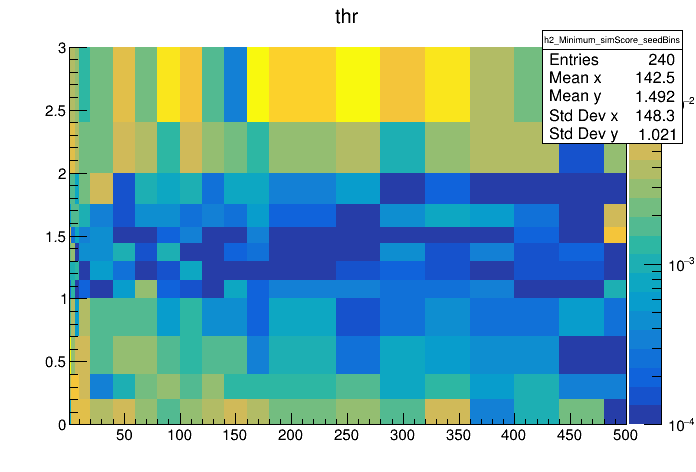

In [44]:
import ROOT as R
from array import array

h2 = R.TH2F("h2_Minimum_simScore_seedBins", "thr", len(ets)-1, array("d", ets), len(etas)-1, array("d", etas))

for _, row in a.iterrows():
    h2.SetBinContent(h2.FindBin(ets[int(row.et_bin)], etas[int(row.eta_bin)]), row.thr)
    
c = R.TCanvas()
h2.Draw("COLZ")
c.SetLogz()
c.Draw()

out = R.TFile(outputdir+"/simScore.root","RECREATE")
h2.Write()
out.Close()

We loop on all the eta and et bins and apply the best threshold. Then we take the maximum dphi and deta from the seed to study the dimension of the window

# Window dimension after simFraction selection 
## Dimension by eta and Et

In [45]:
# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)
dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

/tmp/ipykernel_994/1387350978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_994/1387350978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))


In [46]:
results = []
for (iet, ieta), g in  dfb.groupby(["et_bin", "eta_bin"]):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)&(simfrac_thr.et_bin == iet)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": 'max' ,
                         "deta_seed": "max", 
                    })
    A["ieta"] = ieta
    A["iet"] = iet
    results.append(A)
    
WS = pd.concat(results)

Text(1, 0, 'Max $\\Delta\\phi(cl-seed)$')

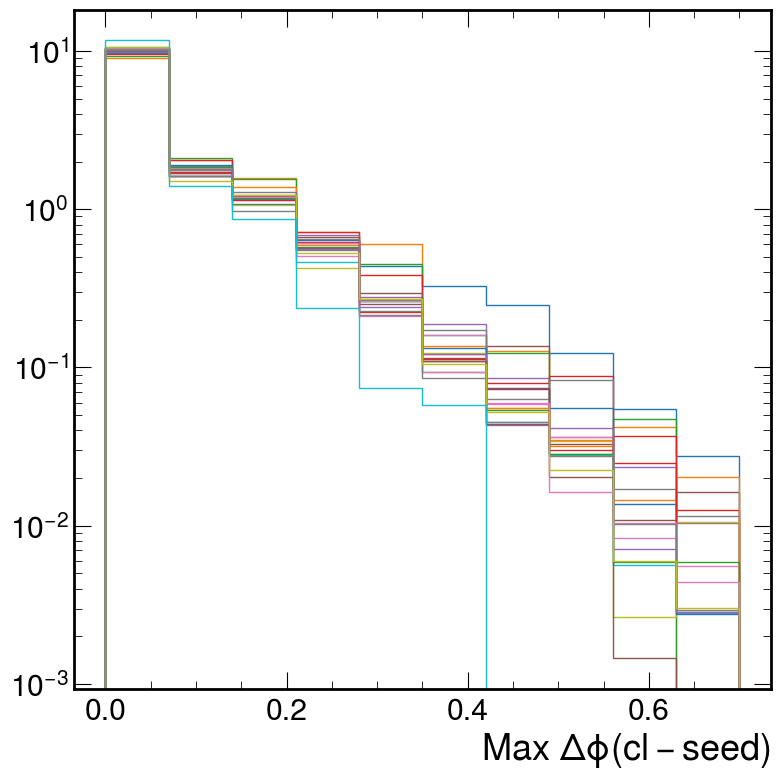

In [47]:
nEt = len(ets)-1
nEta = len(etas)-1
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].dphi_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.7), bins=10, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\phi(cl-seed)$")
#ax.legend()

Text(1, 0, 'Max $\\Delta\\eta(cl-seed)$')

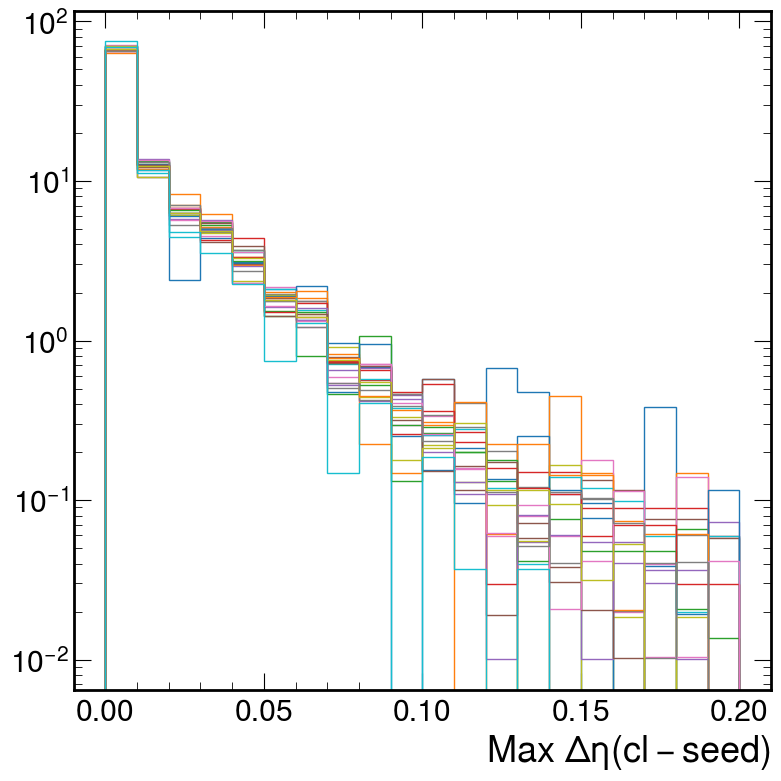

In [48]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].deta_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.2), bins=20, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\eta(cl-seed)$")
#ax.legend()

## Only by seed Eta

In [49]:
results = []
for ieta, g in  dfb.groupby("eta_bin"):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": [np.min, np.max],
                         "deta_seed":  [np.min, np.max]
                    })
    A["ieta"] = ieta
    results.append(A)
    
WS_etaonly = pd.concat(results)

In [50]:
WS_etaonly.dphi_seed.amin

window_index
icnwkdmg    0.0
mgeqcawj    0.0
hgzsiddp    0.0
xyyqyryb    0.0
ijthtfim    0.0
           ... 
khhszyig    0.0
nqnykmqs    0.0
ndifoedf    0.0
guglbhkx    0.0
fggrdsct    0.0
Name: amin, Length: 2395857, dtype: float64

In [51]:
maxq = 0.995
maxWS_eo = WS_etaonly.groupby('ieta').apply(lambda df: pd.Series(
    {"dphi_min": df.dphi_seed.amin.quantile(1-maxq),
     "dphi_max": df.dphi_seed.amax.quantile(maxq),
     "deta_min": df.deta_seed.amin.quantile(1-maxq),
     "deta_max": df.deta_seed.amax.quantile(maxq)}))

maxWS_eo.reset_index(level=0, inplace=True)
maxWS_eo.reset_index(level=0, inplace=True)

Text(0, 1, '$\\Delta\\phi$')

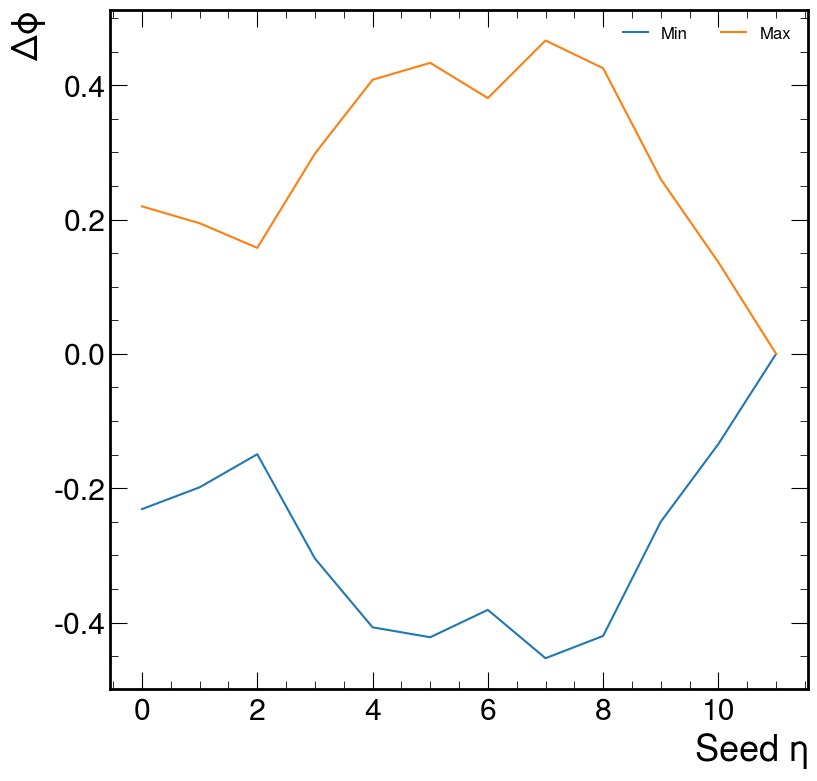

In [52]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")

Text(0, 1, '$\\Delta\\eta$')

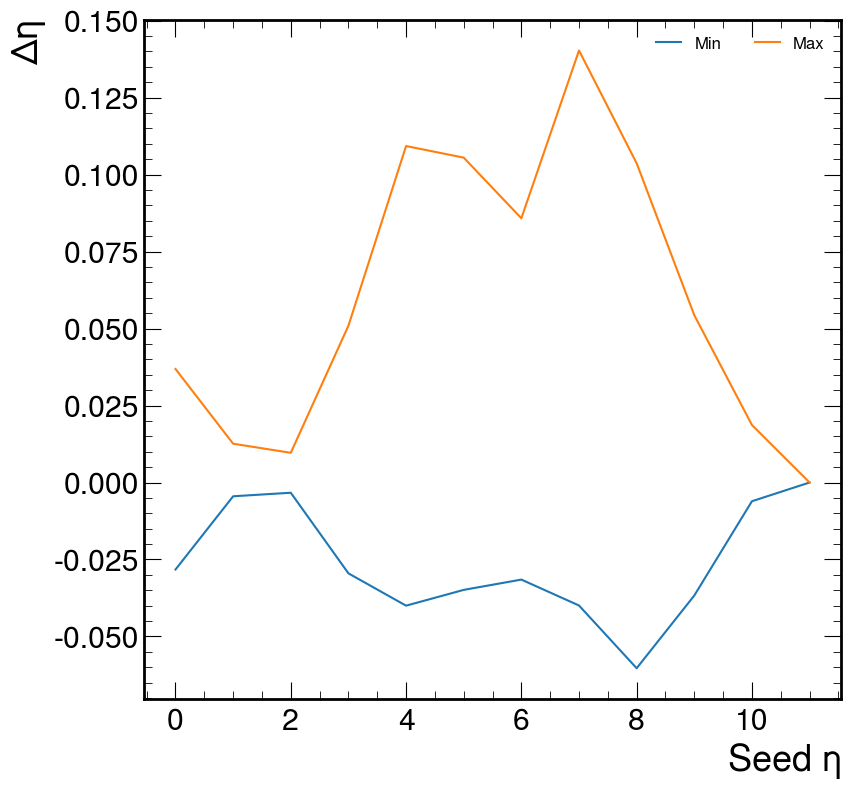

In [53]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(maxWS_eo.ieta, maxWS_eo.deta_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.deta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")